# Eye for Blind – Image Captioning with Attention

# 1. Objective

Eye for Blind: An Assistive Image Captioning System with Visual Attention

This project implements a deep learning model that generates natural language descriptions of images, particularly aimed at visually impaired users. The model leverages an attention mechanism to selectively focus on image regions when generating each word, mimicking human vision.

Inspired by "Show, Attend and Tell" (Xu et al., 2015), this implementation:
1. Uses a CNN encoder (InceptionV3) to extract image features.
2. Applies additive (Bahdanau) attention during decoding.
3. Employs a decoder LSTM to generate captions.
4. Converts generated captions to speech using gTTS.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# 0 (default): All messages (INFO, WARNING, ERROR) are logged.
# 1: INFO messages are not printed.
# 2: INFO and WARNING messages are not printed.
# 3: INFO, WARNING, and ERROR messages are not printed.

import re
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image
from typing import Dict, List, Tuple, Optional
import tensorflow as tf #type: ignore
from tensorflow.keras import layers, Model #type: ignore
from tensorflow.keras.optimizers.schedules import CosineDecay #type: ignore
from tensorflow.keras.losses import SparseCategoricalCrossentropy #type: ignore
from tensorflow.keras.preprocessing.text import Tokenizer #type: ignore
from tensorflow.keras.preprocessing.sequence import pad_sequences #type: ignore
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction #type: ignore
from gtts import gTTS #type: ignore
from IPython.display import Audio, display
import tqdm

In [2]:
CONFIG = {
    # Data
    'image_dir': '/home/flickr30k_images/flickr30k_images',
    'caption_file': '/home/flickr30k_images/flickr30k_images/results.csv',
    'subset_ratio': 0.007,              # Will be overridden manually to 200 images
    'force_subset_images': 200,         # <== NEW: force subset by image count

    # Vocabulary
    'vocab_min_count': 1,               # Include all words to memorize exact text
    'max_length': 30,

    # Model Architecture
    'embedding_dim': 512,
    'units': 512,
    'decoder_dropout': 0.3,

    # Training
    'seed': 42,
    'epochs': 100,                      # High value to let it memorize
    'early_stop': False,                # Disable early stopping
    'patience': 10,
    'learning_rate': 1e-4,
    'grad_clip_value': 5.0,
    'scheduled_sampling_max_prob': 0.0, # Turn off for memorization

    # Performance
    'batch_size': 64,                   # Smaller batch for more precise updates
    'buffer_size': 2000,
    'mixed_precision': False,

    # Checkpoints
    'checkpoint_dir': './checkpoints/overfit_200',
    'save_checkpoints': False,
    'delete_old_checkpoints': True,

    # Attention regularizer
    'attention_reg_lambda': 1.0
}

In [3]:
# Set random seeds for reproducibility
tf.random.set_seed(CONFIG['seed'])
np.random.seed(CONFIG['seed'])
random.seed(CONFIG['seed'])

# Mixed precision policy - RTX 6000 Ada has excellent mixed precision support
if CONFIG['mixed_precision']:
    policy = tf.keras.mixed_precision.Policy('mixed_float16')
    tf.keras.mixed_precision.set_global_policy(policy)
    print("Mixed precision enabled for RTX 6000 Ada")

# Single GPU setup
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    # Enable memory growth for RTX 6000 Ada
    for gpu in physical_devices:
        tf.config.experimental.set_memory_growth(gpu, True)
    
    # Use default strategy for single GPU
    strategy = tf.distribute.get_strategy()
    print(f"Using single GPU: {physical_devices[0].name}, batch size={CONFIG['batch_size']}")
else:
    print("No GPUs found, using CPU")
    strategy = tf.distribute.get_strategy()

# Constants
AUTOTUNE = tf.data.AUTOTUNE

Using single GPU: /physical_device:GPU:0, batch size=64


In [4]:
class DataProcessor:
    def __init__(self, config):
        self.config = config
        self.captions_dict = dict()
        self.tokenizer = None
        self.vocab_size = 0
        self.train_data = []
        self.val_data = []
        self.test_data = []
    
    def load_captions(self) -> Dict[str, List[str]]:
        """Load and convert pipe-delimited Flickr-style caption file to a dict."""
        print(f"Loading captions from {self.config['caption_file']}")
        df = pd.read_csv(self.config['caption_file'], sep='|', header=None, 
                         names=['image_name', 'comment_number', 'comment'], engine='python')
        df['image_name'] = df['image_name'].str.strip()
        df['comment'] = df['comment'].str.strip()
        
        caption_map = {}
        for img, group in df.groupby('image_name'):
            caption_map[img] = group['comment'].tolist()
        
        self.captions_dict = caption_map
        print(f"Loaded {len(caption_map)} images with captions")
        return caption_map
    
    def display_samples(self, num_samples: int = 3):
        """Display random images with all their associated captions."""
        if not self.captions_dict:
            self.load_captions()

        sample_keys = random.sample(list(self.captions_dict.keys()), min(num_samples, len(self.captions_dict)))

        for key in sample_keys:
            img_path = os.path.join(self.config['image_dir'], key)
            try:
                img = Image.open(img_path)
                plt.figure(figsize=(8, 6))
                plt.imshow(img)
                plt.axis('off')
                plt.title(key)
                plt.show()

                for cap in self.captions_dict[key]:
                    print(f"- {cap}")
                print()
            except Exception as e:
                print(f"Error loading image {key}: {e}")

    def preprocess_caption(self, caption: str) -> Optional[str]:
        """Clean and format caption text."""
        if caption is None or not isinstance(caption, str):
            return None
        caption = caption.lower()
        caption = re.sub(r"[^a-z0-9.,? ]", "", caption)
        return f"<start> {caption.strip()} <end>"

    def prepare_captions(self, subset_ratio=1.0):
        """Process captions, build tokenizer & train/val/test splits."""
        if not self.captions_dict:
            self.load_captions()

        # --- 1. clean & tag ----------------------------------------------------
        all_captions = []
        for caps in self.captions_dict.values():
            for c in caps:
                p = self.preprocess_caption(c)
                if p:
                    all_captions.append(p)

        word_counts = Counter(w for cap in all_captions for w in cap.split())
        valid_words = {w for w, cnt in word_counts.items()
                    if cnt >= self.config['vocab_min_count']}

        def keep(c):
            return all(w in valid_words or w in ('<start>', '<end>') for w in c.split())

        filtered = [c for c in all_captions if keep(c)]

        # --- 2. determine max length ------------------------------------------
        lengths = [len(c.split()) for c in filtered]
        self.config['max_length'] = int(np.percentile(lengths, 95))
        print(f"max_length set to {self.config['max_length']}")

        # --- 3. build tokenizer (NO filters so < and > stay) -------------------
        tokenizer = Tokenizer(oov_token="<unk>", filters='', lower=True)
        tokenizer.fit_on_texts(filtered)
        self.tokenizer = tokenizer
        self.vocab_size = len(tokenizer.word_index) + 1
        print(f"vocab size = {self.vocab_size}")

        # --- 4. Build (image, caption) pairs ------------------------------------
        pairs = []
        for img, caps in self.captions_dict.items():
            for c in caps:
                p = self.preprocess_caption(c)
                if p and keep(p):
                    pairs.append((img, p))

        # --- 5. Force fixed number of images if requested -----------------------
        if 'force_subset_images' in self.config and self.config['force_subset_images']:
            requested = self.config['force_subset_images']
            print(f"Forcing subset of exactly {requested} images...")
            all_imgs = list({img for img, _ in pairs})
            if requested > len(all_imgs):
                raise ValueError(f"Requested {requested} images, but only {len(all_imgs)} available.")
            selected_imgs = set(random.sample(all_imgs, requested))
            pairs = [(img, cap) for img, cap in pairs if img in selected_imgs]
            print(f"Subset contains {len(pairs)} (image, caption) pairs from {requested} images.")
        
        # --- 6. Subset by ratio if no forced image count ------------------------
        elif subset_ratio < 1.0:
            orig_len = len(pairs)
            pairs = pairs[:int(len(pairs) * subset_ratio)]
            print(f"Subset by ratio: {len(pairs)} pairs from {orig_len}")

        # --- 7. Split into train/val/test ---------------------------------------
        random.shuffle(pairs)
        n = len(pairs)
        self.train_data, self.val_data, self.test_data = (
            pairs[:int(0.8 * n)],
            pairs[int(0.8 * n):int(0.9 * n)],
            pairs[int(0.9 * n):]
        )
        print(f"split → train {len(self.train_data)} | val {len(self.val_data)} | test {len(self.test_data)}")

        return filtered

        
    def encode_caption(self, caption: str) -> Tuple[np.ndarray, int]:
        """Convert caption text to sequence of token ids."""
        if self.tokenizer is None:
            raise ValueError("Tokenizer not initialized. Call prepare_captions first.")
        
        seq = self.tokenizer.texts_to_sequences([caption])[0]
        padded_seq = pad_sequences([seq], maxlen=self.config['max_length'], padding='post')[0]
        return padded_seq, len(seq)

    @tf.function(input_signature=[tf.TensorSpec([], tf.string)])
    def _base_decode(self, path: tf.Tensor) -> tf.Tensor:
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)          # [0,1]
        return img                                                   # (h,w,3)

    @tf.function(input_signature=[tf.TensorSpec([], tf.string)])
    def load_image_train(self, path: tf.Tensor) -> tf.Tensor:
        """Augment + preprocess (training only)."""
        img = self._base_decode(path)
        img = tf.image.random_flip_left_right(img)                   # aug ①

        # resize shorter side→342 then *random* crop 299×299
        shape = tf.shape(img)[:2]
        scale = 342. / tf.cast(tf.reduce_min(shape), tf.float32)
        new_hw = tf.cast(tf.cast(shape, tf.float32) * scale, tf.int32)
        img = tf.image.resize(img, new_hw)
        img = tf.image.random_crop(img, size=[299, 299, 3])          # aug ②

        img = tf.keras.applications.inception_v3.preprocess_input(img)
        return tf.ensure_shape(img, [299, 299, 3])

    @tf.function(input_signature=[tf.TensorSpec([], tf.string)])
    def load_image_eval(self, path: tf.Tensor) -> tf.Tensor:
        """Deterministic centre-crop (validation / inference)."""
        img = self._base_decode(path)

        # resize shorter side→342 then *central* crop 299×299
        shape = tf.shape(img)[:2]
        scale = 342. / tf.cast(tf.reduce_min(shape), tf.float32)
        new_hw = tf.cast(tf.cast(shape, tf.float32) * scale, tf.int32)
        img = tf.image.resize(img, new_hw)
        img = tf.image.resize_with_crop_or_pad(img, 299, 299)

        img = tf.keras.applications.inception_v3.preprocess_input(img)
        return tf.ensure_shape(img, [299, 299, 3])

    def data_generator(self, data):
        """Generator for *training* / *val* datasets."""
        for img, cap in data:
            img_path = os.path.join(self.config['image_dir'], img)
            img_tensor = self.load_image_train(tf.convert_to_tensor(img_path))
            token_ids, cap_len = self.encode_caption(cap)
            yield img_tensor, token_ids, cap_len
    
    def build_dataset(self, data, shuffle=True, cache=True, training: bool=True):
        """Create a tf.data.Dataset optimized for single GPU."""
        output_signature = (
            tf.TensorSpec((299, 299, 3), tf.float32),
            tf.TensorSpec((self.config['max_length'],), tf.int32),
            tf.TensorSpec((), tf.int32)
        )

        ds = tf.data.Dataset.from_generator(
            lambda: self.data_generator(data),
            output_signature=output_signature
        )

        if cache:
            ds = ds.cache()
        if shuffle:
            ds = ds.shuffle(self.config['buffer_size'])

        ds = ds.batch(self.config['batch_size'])
        ds = ds.prefetch(AUTOTUNE)
        return ds

    def prepare_datasets(self):
        """Prepare all datasets for training/validation/testing."""
        if not self.train_data:
            self.prepare_captions()

        print("Building datasets...")
        train_ds = self.build_dataset(self.train_data)
        val_ds = self.build_dataset(self.val_data)
        test_ds = self.build_dataset(self.test_data, shuffle=False)
        
        return train_ds, val_ds, test_ds

In [5]:
class Encoder(Model):
    """
    Inception-V3 feature extractor with an optional
    `unfreeze_top_layers()` helper for later fine-tuning.
    """
    def __init__(self):
        super().__init__(name="encoder")
        base = tf.keras.applications.InceptionV3(
            include_top=False, weights='imagenet',
            input_shape=(299, 299, 3))
        base.trainable = False                                      # phase-1: frozen
        self.cnn = Model(inputs=base.input, outputs=base.get_layer('mixed10').output)
        self.reshape = layers.Reshape((-1, 2048))                  # L=64 for 8×8 grid

    def unfreeze_top_layers(self, n: int = 2):
        """
        Fine-tune: unfreeze the last *n* Inception blocks (default: mixed9 & mixed10).
        Call **after** initial caption training for best accuracy.
        """
        for layer in self.cnn.layers[-n:]:
            layer.trainable = True

    def call(self, x):                                             # (B,299,299,3)
        x = self.cnn(x)                                            # (B,8,8,2048)
        return self.reshape(x)                                     # (B,64,2048)

In [6]:
class BahdanauAttention(layers.Layer):
    def __init__(self, units):
        super().__init__(name="attention")
        self.W1 = layers.Dense(units)
        self.W2 = layers.Dense(units)
        self.V = layers.Dense(1)
    
    def call(self, features, hidden):
        hidden_time = tf.expand_dims(hidden, 1)
        score = self.V(tf.nn.tanh(self.W1(features) + self.W2(hidden_time)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = tf.reduce_sum(attention_weights * features, axis=1)
        return context_vector, tf.squeeze(attention_weights, -1)

In [7]:
class Decoder(Model):
    """
    Attention decoder with configurable dropout via config.
    """
    def __init__(self, embedding_dim: int, units: int, vocab_size: int, dropout: float = 0.5):
        super().__init__(name="decoder")
        self.units = units

        self.embedding = layers.Embedding(vocab_size, embedding_dim)
        self.attention = BahdanauAttention(units)
        self.f_beta    = layers.Dense(1, activation="sigmoid")
        self.lstm      = layers.LSTM(units, return_sequences=True, return_state=True)
        self.dropout   = layers.Dropout(dropout)

        self.deep_proj = layers.Dense(units * 2)
        self.fc        = layers.Dense(vocab_size)

    def call(self, x, features, hidden, cell):
        context, alpha = self.attention(features, hidden)
        context = self.f_beta(hidden) * context

        x = self.embedding(x)
        lstm_input = tf.concat([tf.expand_dims(context, 1), x], -1)

        hidden = tf.cast(hidden, lstm_input.dtype)
        cell   = tf.cast(cell, lstm_input.dtype)

        lstm_out, h_t, c_t = self.lstm(lstm_input, initial_state=[hidden, cell])
        lstm_out = tf.squeeze(lstm_out, 1)

        proj = self.deep_proj(tf.concat([lstm_out, context], -1))
        proj = tf.reshape(proj, (-1, self.units, 2))
        maxout = tf.reduce_max(proj, axis=-1)
        maxout = self.dropout(maxout)

        logits = self.fc(maxout)
        return tf.expand_dims(logits, 1), h_t, c_t, alpha

In [8]:
class ImageCaptioningModel:
    def __init__(self, config, processor):
        self.config          = config
        self.processor       = processor
        self.encoder         = None
        self.decoder         = None
        self.optimizer       = None
        self.loss_fn         = None
        self.ckpt_manager    = None

        self.best_bleu       = 0.0
        self.train_loss_log  = []
        self.train_bleu_log  = []
        self.val_bleu_log    = []
        self.bleu_subset_idx = None  

        self.smoothie = SmoothingFunction().method4
    
    def build_model(self):
        print("Building model for single GPU...")
        self.encoder = Encoder()
        self.decoder = Decoder(
            embedding_dim=self.config['embedding_dim'],
            units=self.config['units'],
            vocab_size=self.processor.vocab_size,
            dropout=self.config.get('decoder_dropout', 0.5)
        )

        lr_schedule = CosineDecay(
            initial_learning_rate=self.config['learning_rate'],
            decay_steps=10000
        )
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
        self.loss_fn = SparseCategoricalCrossentropy(from_logits=True, reduction='none')

        if not self.config.get('save_checkpoints', True):
            print("Checkpoint saving disabled.")
            return

        ckpt_dir = self.config['checkpoint_dir']
        os.makedirs(ckpt_dir, exist_ok=True)

        max_keep = 1 if self.config.get('delete_old_checkpoints', True) else 5
        ckpt = tf.train.Checkpoint(encoder=self.encoder,
                                decoder=self.decoder,
                                optimizer=self.optimizer)
        self.ckpt_manager = tf.train.CheckpointManager(ckpt, ckpt_dir, max_to_keep=max_keep)

        if self.ckpt_manager.latest_checkpoint:
            ckpt.restore(self.ckpt_manager.latest_checkpoint)
            print(f"Restored from checkpoint: {self.ckpt_manager.latest_checkpoint}")

    
    def summary(self):
        """Print model summaries for Encoder, Attention, and Decoder."""
        print("Building model summaries...")

        # Dummy inputs
        dummy_image = tf.random.uniform((1, 299, 299, 3))
        dummy_features = tf.random.uniform((1, 64, 2048))
        dummy_hidden = tf.zeros((1, self.config['units']))
        dummy_cell = tf.zeros((1, self.config['units']))
        dummy_token = tf.zeros((1, 1), dtype=tf.int32)

        # --- Encoder Summary ---
        print("\nEncoder Summary:")
        self.encoder(dummy_image)
        self.encoder.summary()

        # --- Bahdanau Attention Summary ---
        print("\nBahdanau Attention Summary:")
        attention_layer = BahdanauAttention(self.config['units'])
        features_input = tf.keras.Input(shape=(64, 2048), name="features")
        hidden_input = tf.keras.Input(shape=(self.config['units'],), name="hidden")
        context_vector, attn_weights = attention_layer(features_input, hidden_input)
        attention_model = tf.keras.Model(inputs=[features_input, hidden_input], outputs=[context_vector, attn_weights])
        attention_model.summary()

        # --- Decoder Summary ---
        print("\nDecoder Summary:")
        self.decoder(dummy_token, dummy_features, dummy_hidden, dummy_cell)
        self.decoder.summary()

    @tf.function
    def train_step(self,
                   img_tensor: tf.Tensor,
                   target:     tf.Tensor,
                   cap_len:    tf.Tensor) -> tf.Tensor:
        """
        Single step with:
        • β-gated attention + doubly-stochastic regulariser   (already present)
        • **Scheduled sampling** controlled by `self.ss_prob`.
        """
        batch_size = tf.shape(img_tensor)[0]
        hidden     = tf.zeros((batch_size, self.config['units']))
        cell       = tf.zeros_like(hidden)

        start_tok  = self.processor.tokenizer.word_index['<start>']
        dec_input  = tf.expand_dims(tf.repeat(start_tok, batch_size), 1)

        attention_accum = None
        total_ce_loss   = 0.0

        with tf.GradientTape() as tape:
            features = self.encoder(img_tensor)  # (B, L, 2048)

            for t in tf.range(1, self.config['max_length']):
                logits, hidden, cell, alpha = self.decoder(
                    dec_input, features, hidden, cell)

                # accumulate α for doubly-stochastic term
                attention_accum = (alpha if attention_accum is None
                                   else attention_accum + alpha)

                # CE loss
                ce_t  = self.loss_fn(target[:, t], tf.squeeze(logits, 1))
                mask  = tf.cast(target[:, t] > 0, tf.float32)
                total_ce_loss += tf.reduce_sum(ce_t * mask)

                # ---- scheduled sampling decision ----
                # predicted tokens
                pred_ids = tf.argmax(logits, -1, output_type=tf.int32)  # (B,1) → (B,)
                pred_ids = tf.squeeze(pred_ids, -1)

                # Bernoulli mask: 1 → use prediction
                ss_mask = tf.random.uniform((batch_size,)) < self.ss_prob
                next_ids = tf.where(ss_mask, pred_ids, target[:, t])

                dec_input = tf.expand_dims(next_ids, 1)

            # normalise CE by real tokens
            total_tokens = tf.reduce_sum(tf.cast(cap_len, tf.float32))
            ce_loss      = total_ce_loss / total_tokens

            # doubly-stochastic regulariser
            lambda_reg = self.config.get('attention_reg_lambda', 1.0)
            reg_loss   = tf.reduce_mean(tf.square(1.0 - attention_accum))
            loss       = ce_loss + lambda_reg * reg_loss

            if self.config['mixed_precision']:
                loss = tf.cast(loss, tf.float32)

        variables = self.encoder.trainable_variables + self.decoder.trainable_variables
        grads     = tape.gradient(loss, variables)

        if self.config['mixed_precision']:
            grads = [tf.cast(g, tf.float32) if g is not None else None
                     for g in grads]

        grads, _ = tf.clip_by_global_norm(grads, self.config['grad_clip_value'])
        self.optimizer.apply_gradients(zip(grads, variables))

        return loss

    def beam_search_decode(self,
                           image_path: str,
                           beam_size: int = 5,
                           length_penalty: float = 0.7,
                           return_attention: bool = False):
        """Beam-search with deterministic crop."""
        img_tensor = tf.expand_dims(
            self.processor.load_image_eval(tf.convert_to_tensor(image_path)), 0
        )
        base_features = self.encoder(img_tensor)       # (1,L,2048)

        start_id = self.processor.tokenizer.word_index['<start>']
        end_id   = self.processor.tokenizer.word_index['<end>']

        beams = [{'seq':[start_id],
                  'score':0.0,
                  'hidden':tf.zeros((1,self.config['units'])),
                  'cell':tf.zeros((1,self.config['units'])),
                  'alphas':[]}]

        completed = []
        for _ in range(self.config['max_length']):
            candidates = []
            for b in beams:
                last_id = b['seq'][-1]
                if last_id == end_id:
                    completed.append(b); continue
                dec_in = tf.expand_dims([last_id], 0)
                logits, h, c, alpha = self.decoder(dec_in, base_features,
                                                   b['hidden'], b['cell'])
                log_probs = tf.nn.log_softmax(logits[0,0])
                top_ids = tf.math.top_k(log_probs, k=beam_size).indices.numpy()
                for tok in top_ids:
                    tok = int(tok)
                    candidates.append({
                        'seq':   b['seq']+[tok],
                        'score': b['score']+float(log_probs[tok]),
                        'hidden':h,
                        'cell':  c,
                        'alphas':b['alphas']+[alpha[0].numpy()]})
            if not candidates: break
            def lp(b): return b['score']/(len(b['seq'])**length_penalty)
            candidates.sort(key=lp, reverse=True)
            beams = candidates[:beam_size]
            if len(completed) >= beam_size: break

        best = max(completed+beams,
                   key=lambda b: b['score']/(len(b['seq'])**length_penalty))
        words = [self.processor.tokenizer.index_word.get(i,'')
                 for i in best['seq']
                 if self.processor.tokenizer.index_word.get(i,'') not in
                 ('<start>','<end>','<unk>')]
        return (words, best['alphas']) if return_attention else words

    def greedy_decode(self, image_path: str, return_attention=False):
        """Generate caption via greedy decoding (deterministic crop)."""
        img_tensor = tf.expand_dims(
            self.processor.load_image_eval(tf.convert_to_tensor(image_path)), 0
        )

        features = self.encoder(img_tensor)
        hidden = tf.zeros((1, self.config['units']))
        cell   = tf.zeros_like(hidden)
        dec_input = tf.expand_dims(
            [self.processor.tokenizer.word_index['<start>']], 0
        )

        result, alphas = [], []
        for _ in range(self.config['max_length']):
            logits, hidden, cell, alpha = self.decoder(
                dec_input, features, hidden, cell
            )
            pred_id = tf.argmax(logits[0, 0]).numpy()
            word = self.processor.tokenizer.index_word.get(pred_id, '')
            if word == '<end>':
                break
            if word not in ('<start>', '<unk>'):
                result.append(word)
            alphas.append(alpha[0].numpy())
            dec_input = tf.expand_dims([pred_id], 0)

        return (result, alphas) if return_attention else result

    def evaluate_bleu(self, test_data, max_samples=None):
        """Calculate BLEU scores on test data."""
        refs, hyps = [], []
        data_to_eval = test_data[:max_samples] if max_samples else test_data
        
        for img_name, _ in tqdm.tqdm(data_to_eval):
            image_path = os.path.join(self.config['image_dir'], img_name)
            hyp = self.greedy_decode(image_path)
            
            # Process ground truth captions
            gt = [self.processor.preprocess_caption(c).split() for c in self.processor.captions_dict[img_name][:5]]
            gt = [[w for w in cap if w not in ('<start>', '<end>')] for cap in gt]
            
            refs.append(gt)
            hyps.append(hyp)
        
        # Calculate BLEU scores for different n-grams
        bleu_scores = {}
        for i in range(1, 5):
            weights = tuple([1.0/i]*i + [0.0]*(4-i))
            score = corpus_bleu(refs, hyps, weights=weights, smoothing_function=self.smoothie)
            bleu_scores[f'bleu-{i}'] = score
            print(f"BLEU-{i}: {score:.4f}")
        
        return bleu_scores
    
    def train(self, train_ds, val_data, epochs=None, subset_size: int = 200):
        if epochs is None:
            epochs = self.config['epochs']

        if self.bleu_subset_idx is None:
            total_train = len(self.processor.train_data)
            subset_size = min(subset_size, total_train)
            self.bleu_subset_idx = random.sample(range(total_train), subset_size)

        def _subset(data, idx):
            return [data[i] for i in idx]

        patience = self.config.get('patience', 8)
        wait = 0
        apply_early_stop = self.config.get('early_stop', True)
        self.ss_max_prob = self.config.get('scheduled_sampling_max_prob', 0.0)

        for epoch in range(epochs):
            self.ss_prob = self.ss_max_prob * epoch / max(1, epochs - 1)
            print(f"\nEpoch {epoch+1}/{epochs}  (ε = {self.ss_prob:.3f})")

            start, total_loss, step = time.time(), 0.0, 0
            progbar = tf.keras.utils.Progbar(None, stateful_metrics=['loss'])

            for batch, (img_tensor, target, cap_len) in enumerate(train_ds):
                if batch == 0 and progbar.target is None:
                    progbar.target = len(self.processor.train_data) // self.config['batch_size'] + 1

                batch_loss = self.train_step(img_tensor, target, cap_len)
                total_loss += batch_loss
                progbar.update(batch + 1, values=[('loss', batch_loss)])
                step += 1

            avg_loss = total_loss / step
            self.train_loss_log.append(float(avg_loss))

            train_subset = _subset(self.processor.train_data, self.bleu_subset_idx)
            train_bleu = self.evaluate_bleu(train_subset)['bleu-4']
            self.train_bleu_log.append(train_bleu)

            val_bleu = self.evaluate_bleu(val_data)['bleu-4']
            self.val_bleu_log.append(val_bleu)

            if self.ckpt_manager and self.config.get('save_checkpoints', True):
                self.ckpt_manager.save()

            if val_bleu > self.best_bleu:
                self.best_bleu = val_bleu
                wait = 0
            else:
                wait += 1
                if apply_early_stop and wait >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

            print(f"Epoch {epoch+1}: loss={avg_loss:.4f}  "
                f"train-BLEU={train_bleu:.4f}  val-BLEU={val_bleu:.4f}  "
                f"time={time.time()-start:.1f}s", flush=True)

        return self.train_loss_log, self.val_bleu_log
    
    def plot_attention(self, image_path: str, caption: list, alphas: list):
        """Improved visualization of attention with better contrast and 299x299 alignment."""
        img = np.array(Image.open(image_path).resize((299, 299)))
        fig = plt.figure(figsize=(15, 8))

        for t in range(len(caption)):
            ax = fig.add_subplot(3, int(np.ceil(len(caption) / 3)), t + 1)
            ax.imshow(img)
            ax.axis('off')

            alpha = np.array(alphas[t])
            attention_shape = int(np.sqrt(alpha.size))
            alpha = alpha.reshape((attention_shape, attention_shape))

            # Normalize and boost contrast
            alpha -= alpha.min()
            if alpha.max() > 0:
                alpha /= alpha.max()

            # Resize attention map to 299×299
            alpha_resized = Image.fromarray(np.uint8(255 * alpha)).resize((299, 299), resample=Image.BICUBIC)
            alpha_resized = np.array(alpha_resized) / 255.0  # back to [0,1] float

            ax.imshow(alpha_resized, cmap='jet', alpha=0.5, extent=(0, 299, 299, 0))
            ax.set_title(f"{t+1}: '{caption[t]}'", fontsize=10)

        plt.tight_layout()
        plt.show()

    def plot_history(self):
        """Plot loss curve **and** both train/val BLEU-4 curves."""
        plt.figure(figsize=(14, 5))

        # --- left: training loss ---
        plt.subplot(1, 2, 1)
        plt.plot(self.train_loss_log, label='Train Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Cross-Entropy Loss')
        plt.title('Training Loss')
        plt.grid(True)
        plt.legend()

        # --- right: BLEU-4 ---
        plt.subplot(1, 2, 2)
        if self.train_bleu_log:
            plt.plot(self.train_bleu_log, label='Train BLEU-4')
        plt.plot(self.val_bleu_log,   label='Val BLEU-4')
        plt.xlabel('Epoch')
        plt.ylabel('BLEU-4')
        plt.title('BLEU-4 Scores')
        plt.grid(True)
        plt.legend()

        plt.tight_layout()
        plt.show()
    
    def speak_caption(self, caption: str, filename="caption_audio.mp3"):
        """Generate speech audio from caption text."""
        if not caption:
            print("Empty caption, nothing to speak")
            return
            
        tts = gTTS(text=caption, lang='en')
        tts.save(filename)
        display(Audio(filename))
        print(f"Audio saved to {filename}")
    
    def demo(self,
             image_path: str,
             filename: str = "caption_audio.mp3",
             beam_size: int = 5,
             length_penalty: float = 0.7):
        """
        End-to-end demo (beam-search inference) in the following order:
          1. Original image
          2. Ground-truth captions
          3. Generated caption
          4. Audio playback
          5. Attention heat-maps
        """
        if not os.path.exists(image_path):
            print(f"Image not found: {image_path}")
            return

        # ---------- 1. original image ----------
        img = Image.open(image_path)
        plt.figure(figsize=(8, 6))
        plt.imshow(img)
        plt.axis('off')
        plt.show()

        # ---------- 2. ground-truth captions ----------
        img_name = os.path.basename(image_path)
        gt_caps = self.processor.captions_dict.get(img_name, [])
        if gt_caps:
            print("Ground-truth captions:")
            for cap in gt_caps:
                print(f"- {cap}")
        else:
            print("No ground-truth captions found.")

        # ---------- 3. caption generation ----------
        words, attention = self.beam_search_decode(
            image_path,
            beam_size=beam_size,
            length_penalty=length_penalty,
            return_attention=True
        )
        caption = " ".join(words)
        print("\nGenerated caption:")
        print(caption)

        # ---------- 4. audio ----------
        self.speak_caption(caption, filename=filename)

        # ---------- 5. attention plot ----------
        self.plot_attention(image_path, words, attention)


    def prime_dataset(self, ds, steps: int = None) -> None:
        """
        Pre-fill a tf.data shuffle buffer so the first training epoch
        starts without the usual “Filling up shuffle buffer …” pause.

        Args
        ----
        ds    : the *un-iterated* tf.data.Dataset you’ll pass to train()
        steps : number of iterator steps to advance; default uses
                buffer_size // batch_size + 1 from config.
        """
        if steps is None:
            steps = self.config['buffer_size'] // self.config['batch_size'] + 1

        it = iter(ds)
        for _ in range(steps):
            try:
                next(it)
            except StopIteration:  # dataset shorter than requested priming
                break

    def fine_tune_cnn(self,
                      train_ds,
                      val_data,
                      layers_to_unfreeze: int = 2,
                      lr: float = 1e-5,
                      epochs: int = 1):
        """
        Phase-2 fine-tuning of the top Inception blocks.
        Call after initial caption training for an extra accuracy bump.
        """
        print(f"\nUnfreezing top {layers_to_unfreeze} Inception blocks …")
        self.encoder.unfreeze_top_layers(layers_to_unfreeze)

        # New, low learning-rate optimiser
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

        print(f"Fine-tuning CNN for {epochs} epoch(s) at lr={lr} …")
        self.train(train_ds, val_data, epochs=epochs)

        print("CNN fine-tune finished.")

In [9]:
processor = DataProcessor(CONFIG)

In [10]:
_ = processor.load_captions()

Loading captions from /home/flickr30k_images/flickr30k_images/results.csv
Loaded 31784 images with captions


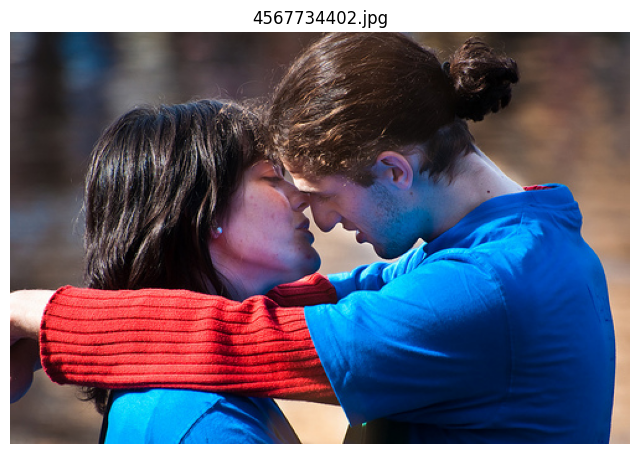

- A man in a blue and red shirt hugs a woman in a blue top .
- A man and a woman are about to kiss .
- A woman and a man getting closer .
- A couple that is about to kiss .
- Two young people are kissing .



In [11]:
processor.display_samples(1)

In [12]:
processor.prepare_captions(subset_ratio=CONFIG['subset_ratio'])[:20]

max_length set to 25
vocab size = 20062
Forcing subset of exactly 200 images...
Subset contains 1000 (image, caption) pairs from 200 images.
split → train 800 | val 100 | test 100


['<start> two young guys with shaggy hair look at their hands while hanging out in the yard . <end>',
 '<start> two young , white males are outside near many bushes . <end>',
 '<start> two men in green shirts are standing in a yard . <end>',
 '<start> a man in a blue shirt standing in a garden . <end>',
 '<start> two friends enjoy time spent together . <end>',
 '<start> several men in hard hats are operating a giant pulley system . <end>',
 '<start> workers look down from up above on a piece of equipment . <end>',
 '<start> two men working on a machine wearing hard hats . <end>',
 '<start> four men on top of a tall structure . <end>',
 '<start> three men on a large rig . <end>',
 '<start> a child in a pink dress is climbing up a set of stairs in an entry way . <end>',
 '<start> a little girl in a pink dress going into a wooden cabin . <end>',
 '<start> a little girl climbing the stairs to her playhouse . <end>',
 '<start> a little girl climbing into a wooden playhouse <end>',
 '<start>

In [13]:
# Create datasets
train_ds, val_ds, _ = processor.prepare_datasets()

Building datasets...


In [14]:
model = ImageCaptioningModel(CONFIG, processor)
model.build_model()

Building model for single GPU...
Checkpoint saving disabled.


In [15]:
model.summary()

Building model summaries...

Encoder Summary:
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 8, 8, 2048)        21802784  
                                                                 
 reshape (Reshape)           multiple                  0         
                                                                 
Total params: 21,802,784
Trainable params: 0
Non-trainable params: 21,802,784
_________________________________________________________________

Bahdanau Attention Summary:
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 features (InputLayer)          [(None, 64, 2048)]   0           []                               
                                                      

In [16]:
model.prime_dataset(train_ds, steps=20)

In [17]:
len(processor.val_data)

100

In [18]:
reduced_val = random.sample(processor.val_data, min(len(processor.val_data), 10))

In [19]:
model.prime_dataset(ds=train_ds, steps=50)

In [20]:
# model.train(train_ds, processor.val_data)
model.train(train_ds=train_ds, val_data=reduced_val)


Epoch 1/100  (ε = 0.000)
13/13 [==============================] - 11s 433ms/step - loss: 8.8974


100%|██████████| 200/200 [01:04<00:00,  3.10it/s]


BLEU-1: 0.1150
BLEU-2: 0.0045
BLEU-3: 0.0012
BLEU-4: 0.0005


100%|██████████| 10/10 [00:03<00:00,  3.09it/s]

BLEU-1: 0.1040
BLEU-2: 0.0155
BLEU-3: 0.0066
BLEU-4: 0.0037
Epoch 1: loss=9.2162  train-BLEU=0.0005  val-BLEU=0.0037  time=78.8s

Epoch 2/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 8.6105

13/13 [==============================] - 2s 172ms/step - loss: 6.3464


100%|██████████| 200/200 [01:04<00:00,  3.12it/s]


BLEU-1: 0.1150
BLEU-2: 0.0045
BLEU-3: 0.0012
BLEU-4: 0.0005


100%|██████████| 10/10 [00:03<00:00,  3.10it/s]

BLEU-1: 0.1040
BLEU-2: 0.0155
BLEU-3: 0.0066
BLEU-4: 0.0037
Epoch 2: loss=7.4638  train-BLEU=0.0005  val-BLEU=0.0037  time=69.7s

Epoch 3/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 5.9192

13/13 [==============================] - 2s 169ms/step - loss: 5.6257


100%|██████████| 200/200 [00:22<00:00,  8.83it/s]


BLEU-1: 0.0306
BLEU-2: 0.0017
BLEU-3: 0.0005
BLEU-4: 0.0002


100%|██████████| 10/10 [00:01<00:00,  8.42it/s]

BLEU-1: 0.0273
BLEU-2: 0.0047
BLEU-3: 0.0021
BLEU-4: 0.0012
Epoch 3: loss=5.6758  train-BLEU=0.0002  val-BLEU=0.0012  time=26.1s



Epoch 4/100  (ε = 0.000)
13/13 [==============================] - 2s 171ms/step - loss: 5.2852


100%|██████████| 200/200 [01:05<00:00,  3.05it/s]


BLEU-1: 0.1150
BLEU-2: 0.0045
BLEU-3: 0.0012
BLEU-4: 0.0005


100%|██████████| 10/10 [00:03<00:00,  3.08it/s]

BLEU-1: 0.1040
BLEU-2: 0.0155
BLEU-3: 0.0066
BLEU-4: 0.0037
Epoch 4: loss=5.3401  train-BLEU=0.0005  val-BLEU=0.0037  time=71.1s

Epoch 5/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 5.2455

13/13 [==============================] - 2s 171ms/step - loss: 5.3544


100%|██████████| 200/200 [01:05<00:00,  3.05it/s]


BLEU-1: 0.1150
BLEU-2: 0.0045
BLEU-3: 0.0012
BLEU-4: 0.0005


100%|██████████| 10/10 [00:03<00:00,  3.08it/s]

BLEU-1: 0.1040
BLEU-2: 0.0155
BLEU-3: 0.0066
BLEU-4: 0.0037
Epoch 5: loss=5.2744  train-BLEU=0.0005  val-BLEU=0.0037  time=71.1s

Epoch 6/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 5.3481

13/13 [==============================] - 2s 172ms/step - loss: 5.2140


100%|██████████| 200/200 [01:04<00:00,  3.09it/s]


BLEU-1: 0.1150
BLEU-2: 0.0045
BLEU-3: 0.0012
BLEU-4: 0.0005


100%|██████████| 10/10 [00:03<00:00,  3.12it/s]

BLEU-1: 0.1040
BLEU-2: 0.0155
BLEU-3: 0.0066
BLEU-4: 0.0037
Epoch 6: loss=5.2231  train-BLEU=0.0005  val-BLEU=0.0037  time=70.2s

Epoch 7/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 5.1599

13/13 [==============================] - 2s 172ms/step - loss: 5.2213


100%|██████████| 200/200 [00:49<00:00,  4.07it/s]


BLEU-1: 0.1791
BLEU-2: 0.0069
BLEU-3: 0.0019
BLEU-4: 0.0009


100%|██████████| 10/10 [00:02<00:00,  3.77it/s]

BLEU-1: 0.1436
BLEU-2: 0.0209
BLEU-3: 0.0089
BLEU-4: 0.0050
Epoch 7: loss=5.1861  train-BLEU=0.0009  val-BLEU=0.0050  time=54.2s

Epoch 8/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 4.9565

13/13 [==============================] - 2s 172ms/step - loss: 5.0688


100%|██████████| 200/200 [00:37<00:00,  5.28it/s]


BLEU-1: 0.2818
BLEU-2: 0.0108
BLEU-3: 0.0030
BLEU-4: 0.0014


100%|██████████| 10/10 [00:01<00:00,  5.19it/s]

BLEU-1: 0.2450
BLEU-2: 0.0344
BLEU-3: 0.0147
BLEU-4: 0.0084
Epoch 8: loss=5.1452  train-BLEU=0.0014  val-BLEU=0.0084  time=42.1s



Epoch 9/100  (ε = 0.000)
13/13 [==============================] - 2s 173ms/step - loss: 5.1192


100%|██████████| 200/200 [00:35<00:00,  5.60it/s]


BLEU-1: 0.3011
BLEU-2: 0.0115
BLEU-3: 0.0032
BLEU-4: 0.0015


100%|██████████| 10/10 [00:01<00:00,  5.55it/s]

BLEU-1: 0.2731
BLEU-2: 0.0381
BLEU-3: 0.0164
BLEU-4: 0.0094
Epoch 9: loss=5.1143  train-BLEU=0.0015  val-BLEU=0.0094  time=39.8s



Epoch 10/100  (ε = 0.000)
13/13 [==============================] - 2s 172ms/step - loss: 5.2010


100%|██████████| 200/200 [00:38<00:00,  5.15it/s]


BLEU-1: 0.3662
BLEU-2: 0.0121
BLEU-3: 0.0032
BLEU-4: 0.0014


100%|██████████| 10/10 [00:01<00:00,  5.08it/s]

BLEU-1: 0.3333
BLEU-2: 0.0399
BLEU-3: 0.0162
BLEU-4: 0.0089
Epoch 10: loss=5.0834  train-BLEU=0.0014  val-BLEU=0.0089  time=43.2s



Epoch 11/100  (ε = 0.000)
13/13 [==============================] - 2s 171ms/step - loss: 5.1049


100%|██████████| 200/200 [00:37<00:00,  5.33it/s]


BLEU-1: 0.3161
BLEU-2: 0.0116
BLEU-3: 0.0032
BLEU-4: 0.0014


100%|██████████| 10/10 [00:01<00:00,  5.29it/s]

BLEU-1: 0.2708
BLEU-2: 0.0379
BLEU-3: 0.0163
BLEU-4: 0.0093
Epoch 11: loss=5.0500  train-BLEU=0.0014  val-BLEU=0.0093  time=41.7s



Epoch 12/100  (ε = 0.000)
13/13 [==============================] - 2s 172ms/step - loss: 5.1587


100%|██████████| 200/200 [00:37<00:00,  5.41it/s]


BLEU-1: 0.3898
BLEU-2: 0.0129
BLEU-3: 0.0034
BLEU-4: 0.0015


100%|██████████| 10/10 [00:01<00:00,  5.33it/s]

BLEU-1: 0.3711
BLEU-2: 0.0442
BLEU-3: 0.0180
BLEU-4: 0.0100
Epoch 12: loss=5.0234  train-BLEU=0.0015  val-BLEU=0.0100  time=41.2s



Epoch 13/100  (ε = 0.000)
13/13 [==============================] - 2s 172ms/step - loss: 5.0936


100%|██████████| 200/200 [00:41<00:00,  4.84it/s]


BLEU-1: 0.3285
BLEU-2: 0.0109
BLEU-3: 0.0029
BLEU-4: 0.0013


100%|██████████| 10/10 [00:02<00:00,  4.82it/s]

BLEU-1: 0.3051
BLEU-2: 0.0367
BLEU-3: 0.0149
BLEU-4: 0.0082
Epoch 13: loss=5.0007  train-BLEU=0.0013  val-BLEU=0.0082  time=45.7s

Epoch 14/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 5.0152

13/13 [==============================] - 2s 172ms/step - loss: 4.9821


100%|██████████| 200/200 [00:44<00:00,  4.46it/s]


BLEU-1: 0.2821
BLEU-2: 0.0094
BLEU-3: 0.0025
BLEU-4: 0.0011


100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

BLEU-1: 0.2571
BLEU-2: 0.0313
BLEU-3: 0.0126
BLEU-4: 0.0069
Epoch 14: loss=4.9642  train-BLEU=0.0011  val-BLEU=0.0069  time=49.5s

Epoch 15/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 4.9069

13/13 [==============================] - 2s 168ms/step - loss: 4.8957


100%|██████████| 200/200 [00:42<00:00,  4.70it/s]


BLEU-1: 0.3139
BLEU-2: 0.0104
BLEU-3: 0.0027
BLEU-4: 0.0012


100%|██████████| 10/10 [00:02<00:00,  4.64it/s]

BLEU-1: 0.2857
BLEU-2: 0.0345
BLEU-3: 0.0140
BLEU-4: 0.0076
Epoch 15: loss=4.9324  train-BLEU=0.0012  val-BLEU=0.0076  time=47.0s

Epoch 16/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 4.8554

13/13 [==============================] - 2s 172ms/step - loss: 4.8776


100%|██████████| 200/200 [00:47<00:00,  4.21it/s]


BLEU-1: 0.2568
BLEU-2: 0.0085
BLEU-3: 0.0022
BLEU-4: 0.0010


100%|██████████| 10/10 [00:02<00:00,  4.15it/s]

BLEU-1: 0.2323
BLEU-2: 0.0284
BLEU-3: 0.0115
BLEU-4: 0.0062
Epoch 16: loss=4.9032  train-BLEU=0.0010  val-BLEU=0.0062  time=52.3s

Epoch 17/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 4.9029

13/13 [==============================] - 2s 172ms/step - loss: 4.7118


100%|██████████| 200/200 [00:53<00:00,  3.71it/s]


BLEU-1: 0.2095
BLEU-2: 0.0070
BLEU-3: 0.0018
BLEU-4: 0.0008


100%|██████████| 10/10 [00:02<00:00,  3.59it/s]

BLEU-1: 0.1875
BLEU-2: 0.0233
BLEU-3: 0.0094
BLEU-4: 0.0051
Epoch 17: loss=4.8621  train-BLEU=0.0008  val-BLEU=0.0051  time=59.1s

Epoch 18/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 4.9072

13/13 [==============================] - 2s 171ms/step - loss: 4.5740


100%|██████████| 200/200 [01:04<00:00,  3.09it/s]


BLEU-1: 0.1156
BLEU-2: 0.0045
BLEU-3: 0.0012
BLEU-4: 0.0006


100%|██████████| 10/10 [00:03<00:00,  3.08it/s]

BLEU-1: 0.1040
BLEU-2: 0.0155
BLEU-3: 0.0066
BLEU-4: 0.0037
Epoch 18: loss=4.8173  train-BLEU=0.0006  val-BLEU=0.0037  time=70.3s

Epoch 19/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 4.8315

13/13 [==============================] - 2s 170ms/step - loss: 4.9054


100%|██████████| 200/200 [01:04<00:00,  3.12it/s]


BLEU-1: 0.1260
BLEU-2: 0.0048
BLEU-3: 0.0013
BLEU-4: 0.0006


100%|██████████| 10/10 [00:03<00:00,  3.09it/s]

BLEU-1: 0.1089
BLEU-2: 0.0159
BLEU-3: 0.0067
BLEU-4: 0.0037
Epoch 19: loss=4.7908  train-BLEU=0.0006  val-BLEU=0.0037  time=69.6s

Epoch 20/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 4.8255

13/13 [==============================] - 2s 172ms/step - loss: 4.8979


100%|██████████| 200/200 [01:04<00:00,  3.12it/s]


BLEU-1: 0.1357
BLEU-2: 0.0455
BLEU-3: 0.0073
BLEU-4: 0.0025


100%|██████████| 10/10 [00:03<00:00,  3.10it/s]

BLEU-1: 0.1160
BLEU-2: 0.0381
BLEU-3: 0.0152
BLEU-4: 0.0081
Epoch 20: loss=4.7588  train-BLEU=0.0025  val-BLEU=0.0081  time=69.7s

Epoch 21/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 4.6313

13/13 [==============================] - 2s 172ms/step - loss: 4.8189


100%|██████████| 200/200 [00:52<00:00,  3.80it/s]


BLEU-1: 0.2338
BLEU-2: 0.1018
BLEU-3: 0.0473
BLEU-4: 0.0260


100%|██████████| 10/10 [00:02<00:00,  3.95it/s]

BLEU-1: 0.2176
BLEU-2: 0.0825
BLEU-3: 0.0449
BLEU-4: 0.0284
Epoch 21: loss=4.7019  train-BLEU=0.0260  val-BLEU=0.0284  time=57.5s

Epoch 22/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 4.6859

13/13 [==============================] - 2s 173ms/step - loss: 4.7309


100%|██████████| 200/200 [00:39<00:00,  5.10it/s]


BLEU-1: 0.4842
BLEU-2: 0.2395
BLEU-3: 0.1332
BLEU-4: 0.0826


100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

BLEU-1: 0.3116
BLEU-2: 0.1396
BLEU-3: 0.0691
BLEU-4: 0.0418
Epoch 22: loss=4.6491  train-BLEU=0.0826  val-BLEU=0.0418  time=43.8s



Epoch 23/100  (ε = 0.000)
13/13 [==============================] - 2s 172ms/step - loss: 4.4698


100%|██████████| 200/200 [00:36<00:00,  5.51it/s]


BLEU-1: 0.5506
BLEU-2: 0.2734
BLEU-3: 0.1511
BLEU-4: 0.0943


100%|██████████| 10/10 [00:01<00:00,  5.55it/s]

BLEU-1: 0.5255
BLEU-2: 0.2493
BLEU-3: 0.1189
BLEU-4: 0.0717
Epoch 23: loss=4.5962  train-BLEU=0.0943  val-BLEU=0.0717  time=40.5s



Epoch 24/100  (ε = 0.000)
13/13 [==============================] - 2s 171ms/step - loss: 4.5679


100%|██████████| 200/200 [00:35<00:00,  5.58it/s]


BLEU-1: 0.5596
BLEU-2: 0.2809
BLEU-3: 0.1571
BLEU-4: 0.0987


100%|██████████| 10/10 [00:01<00:00,  5.56it/s]

BLEU-1: 0.5255
BLEU-2: 0.2493
BLEU-3: 0.1189
BLEU-4: 0.0717
Epoch 24: loss=4.5582  train-BLEU=0.0987  val-BLEU=0.0717  time=40.0s



Epoch 25/100  (ε = 0.000)
13/13 [==============================] - 2s 172ms/step - loss: 4.6451


100%|██████████| 200/200 [00:36<00:00,  5.52it/s]


BLEU-1: 0.5556
BLEU-2: 0.2772
BLEU-3: 0.1533
BLEU-4: 0.0954


100%|██████████| 10/10 [00:01<00:00,  5.49it/s]

BLEU-1: 0.5368
BLEU-2: 0.2515
BLEU-3: 0.1191
BLEU-4: 0.0715
Epoch 25: loss=4.5197  train-BLEU=0.0954  val-BLEU=0.0715  time=40.4s



Epoch 26/100  (ε = 0.000)
13/13 [==============================] - 2s 172ms/step - loss: 4.6281


100%|██████████| 200/200 [00:35<00:00,  5.60it/s]


BLEU-1: 0.5614
BLEU-2: 0.2828
BLEU-3: 0.1580
BLEU-4: 0.0992


100%|██████████| 10/10 [00:01<00:00,  5.57it/s]

BLEU-1: 0.5255
BLEU-2: 0.2493
BLEU-3: 0.1189
BLEU-4: 0.0717
Epoch 26: loss=4.4866  train-BLEU=0.0992  val-BLEU=0.0717  time=39.9s



Epoch 27/100  (ε = 0.000)
13/13 [==============================] - 2s 172ms/step - loss: 4.5575


100%|██████████| 200/200 [00:36<00:00,  5.49it/s]


BLEU-1: 0.5552
BLEU-2: 0.2777
BLEU-3: 0.1540
BLEU-4: 0.0961


100%|██████████| 10/10 [00:01<00:00,  5.52it/s]

BLEU-1: 0.5040
BLEU-2: 0.2386
BLEU-3: 0.1135
BLEU-4: 0.0683
Epoch 27: loss=4.4490  train-BLEU=0.0961  val-BLEU=0.0683  time=40.6s



Epoch 28/100  (ε = 0.000)
13/13 [==============================] - 2s 172ms/step - loss: 4.4523


100%|██████████| 200/200 [00:39<00:00,  5.02it/s]


BLEU-1: 0.5096
BLEU-2: 0.2516
BLEU-3: 0.1358
BLEU-4: 0.0829


100%|██████████| 10/10 [00:01<00:00,  5.31it/s]

BLEU-1: 0.5292
BLEU-2: 0.2402
BLEU-3: 0.1123
BLEU-4: 0.0668
Epoch 28: loss=4.4134  train-BLEU=0.0829  val-BLEU=0.0668  time=44.0s

Epoch 29/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 4.3932

13/13 [==============================] - 2s 173ms/step - loss: 4.4986


100%|██████████| 200/200 [00:56<00:00,  3.55it/s]


BLEU-1: 0.3257
BLEU-2: 0.1499
BLEU-3: 0.0764
BLEU-4: 0.0446


100%|██████████| 10/10 [00:02<00:00,  3.77it/s]

BLEU-1: 0.3122
BLEU-2: 0.1321
BLEU-3: 0.0591
BLEU-4: 0.0338
Epoch 29: loss=4.3846  train-BLEU=0.0446  val-BLEU=0.0338  time=61.4s

Epoch 30/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 4.1980

13/13 [==============================] - 2s 172ms/step - loss: 4.2082


100%|██████████| 200/200 [01:02<00:00,  3.19it/s]


BLEU-1: 0.2727
BLEU-2: 0.1261
BLEU-3: 0.0647
BLEU-4: 0.0377


100%|██████████| 10/10 [00:03<00:00,  3.11it/s]

BLEU-1: 0.2317
BLEU-2: 0.0991
BLEU-3: 0.0443
BLEU-4: 0.0252
Epoch 30: loss=4.3415  train-BLEU=0.0377  val-BLEU=0.0252  time=68.4s

Epoch 31/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 4.2187

13/13 [==============================] - 2s 172ms/step - loss: 4.2022


100%|██████████| 200/200 [01:02<00:00,  3.21it/s]


BLEU-1: 0.2877
BLEU-2: 0.1351
BLEU-3: 0.0678
BLEU-4: 0.0390


100%|██████████| 10/10 [00:03<00:00,  3.30it/s]

BLEU-1: 0.2597
BLEU-2: 0.1137
BLEU-3: 0.0497
BLEU-4: 0.0279
Epoch 31: loss=4.3094  train-BLEU=0.0390  val-BLEU=0.0279  time=67.7s

Epoch 32/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 4.1927

13/13 [==============================] - 2s 173ms/step - loss: 4.3363


100%|██████████| 200/200 [01:03<00:00,  3.14it/s]


BLEU-1: 0.2492
BLEU-2: 0.1251
BLEU-3: 0.0638
BLEU-4: 0.0369


100%|██████████| 10/10 [00:03<00:00,  3.13it/s]

BLEU-1: 0.2120
BLEU-2: 0.0986
BLEU-3: 0.0439
BLEU-4: 0.0249
Epoch 32: loss=4.2867  train-BLEU=0.0369  val-BLEU=0.0249  time=69.2s

Epoch 33/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 4.2095

13/13 [==============================] - 2s 172ms/step - loss: 4.2740


100%|██████████| 200/200 [01:04<00:00,  3.10it/s]


BLEU-1: 0.2584
BLEU-2: 0.1279
BLEU-3: 0.0645
BLEU-4: 0.0371


100%|██████████| 10/10 [00:03<00:00,  3.09it/s]

BLEU-1: 0.2120
BLEU-2: 0.0986
BLEU-3: 0.0439
BLEU-4: 0.0249
Epoch 33: loss=4.2557  train-BLEU=0.0371  val-BLEU=0.0249  time=70.1s

Epoch 34/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 4.2132

13/13 [==============================] - 2s 173ms/step - loss: 4.3166


100%|██████████| 200/200 [01:04<00:00,  3.10it/s]


BLEU-1: 0.2496
BLEU-2: 0.1271
BLEU-3: 0.0649
BLEU-4: 0.0374


100%|██████████| 10/10 [00:03<00:00,  3.09it/s]

BLEU-1: 0.2080
BLEU-2: 0.0976
BLEU-3: 0.0436
BLEU-4: 0.0248
Epoch 34: loss=4.2324  train-BLEU=0.0374  val-BLEU=0.0248  time=70.1s

Epoch 35/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 4.1642

13/13 [==============================] - 2s 172ms/step - loss: 4.1735


100%|██████████| 200/200 [01:05<00:00,  3.08it/s]


BLEU-1: 0.2465
BLEU-2: 0.1288
BLEU-3: 0.0650
BLEU-4: 0.0373


100%|██████████| 10/10 [00:03<00:00,  3.05it/s]

BLEU-1: 0.2040
BLEU-2: 0.0967
BLEU-3: 0.0433
BLEU-4: 0.0247
Epoch 35: loss=4.1973  train-BLEU=0.0373  val-BLEU=0.0247  time=70.7s

Epoch 36/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 3.9692

13/13 [==============================] - 2s 173ms/step - loss: 4.1612


100%|██████████| 200/200 [01:03<00:00,  3.15it/s]


BLEU-1: 0.2453
BLEU-2: 0.1275
BLEU-3: 0.0640
BLEU-4: 0.0369


100%|██████████| 10/10 [00:03<00:00,  3.13it/s]

BLEU-1: 0.2040
BLEU-2: 0.0967
BLEU-3: 0.0433
BLEU-4: 0.0247
Epoch 36: loss=4.1710  train-BLEU=0.0369  val-BLEU=0.0247  time=69.0s

Epoch 37/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 4.1146

13/13 [==============================] - 2s 172ms/step - loss: 4.2119


100%|██████████| 200/200 [01:03<00:00,  3.13it/s]


BLEU-1: 0.2460
BLEU-2: 0.1283
BLEU-3: 0.0648
BLEU-4: 0.0372


100%|██████████| 10/10 [00:03<00:00,  3.12it/s]

BLEU-1: 0.2040
BLEU-2: 0.0967
BLEU-3: 0.0433
BLEU-4: 0.0247
Epoch 37: loss=4.1426  train-BLEU=0.0372  val-BLEU=0.0247  time=69.5s

Epoch 38/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 4.1124

13/13 [==============================] - 2s 172ms/step - loss: 4.0191


100%|██████████| 200/200 [01:04<00:00,  3.08it/s]


BLEU-1: 0.2418
BLEU-2: 0.1264
BLEU-3: 0.0644
BLEU-4: 0.0370


100%|██████████| 10/10 [00:03<00:00,  3.09it/s]

BLEU-1: 0.2040
BLEU-2: 0.0967
BLEU-3: 0.0433
BLEU-4: 0.0247
Epoch 38: loss=4.1106  train-BLEU=0.0370  val-BLEU=0.0247  time=70.4s

Epoch 39/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 4.0885

13/13 [==============================] - 2s 171ms/step - loss: 4.2366


100%|██████████| 200/200 [01:05<00:00,  3.06it/s]


BLEU-1: 0.2280
BLEU-2: 0.1188
BLEU-3: 0.0607
BLEU-4: 0.0354


100%|██████████| 10/10 [00:03<00:00,  3.05it/s]

BLEU-1: 0.1960
BLEU-2: 0.0948
BLEU-3: 0.0427
BLEU-4: 0.0244
Epoch 39: loss=4.0924  train-BLEU=0.0354  val-BLEU=0.0244  time=70.9s

Epoch 40/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 4.0071

13/13 [==============================] - 2s 172ms/step - loss: 4.1591


100%|██████████| 200/200 [01:04<00:00,  3.09it/s]


BLEU-1: 0.2502
BLEU-2: 0.1304
BLEU-3: 0.0655
BLEU-4: 0.0375


100%|██████████| 10/10 [00:03<00:00,  3.12it/s]

BLEU-1: 0.2080
BLEU-2: 0.0976
BLEU-3: 0.0436
BLEU-4: 0.0248
Epoch 40: loss=4.0743  train-BLEU=0.0375  val-BLEU=0.0248  time=70.3s

Epoch 41/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 3.9961

13/13 [==============================] - 2s 172ms/step - loss: 4.1497


100%|██████████| 200/200 [01:04<00:00,  3.11it/s]


BLEU-1: 0.2462
BLEU-2: 0.1283
BLEU-3: 0.0656
BLEU-4: 0.0379


100%|██████████| 10/10 [00:03<00:00,  3.12it/s]

BLEU-1: 0.2040
BLEU-2: 0.0967
BLEU-3: 0.0433
BLEU-4: 0.0247
Epoch 41: loss=4.0429  train-BLEU=0.0379  val-BLEU=0.0247  time=70.0s

Epoch 42/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 4.0546

13/13 [==============================] - 2s 172ms/step - loss: 4.1210


100%|██████████| 200/200 [01:03<00:00,  3.13it/s]


BLEU-1: 0.2281
BLEU-2: 0.1209
BLEU-3: 0.0629
BLEU-4: 0.0364


100%|██████████| 10/10 [00:03<00:00,  3.12it/s]

BLEU-1: 0.1840
BLEU-2: 0.0918
BLEU-3: 0.0419
BLEU-4: 0.0240
Epoch 42: loss=4.0186  train-BLEU=0.0364  val-BLEU=0.0240  time=69.4s

Epoch 43/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 4.0007

13/13 [==============================] - 2s 172ms/step - loss: 4.0566


100%|██████████| 200/200 [01:03<00:00,  3.16it/s]


BLEU-1: 0.2566
BLEU-2: 0.1353
BLEU-3: 0.0682
BLEU-4: 0.0392


100%|██████████| 10/10 [00:03<00:00,  3.14it/s]

BLEU-1: 0.2049
BLEU-2: 0.0981
BLEU-3: 0.0441
BLEU-4: 0.0252
Epoch 43: loss=3.9929  train-BLEU=0.0392  val-BLEU=0.0252  time=68.9s

Epoch 44/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 3.9200

13/13 [==============================] - 2s 172ms/step - loss: 3.7142


100%|██████████| 200/200 [01:01<00:00,  3.23it/s]


BLEU-1: 0.2601
BLEU-2: 0.1352
BLEU-3: 0.0686
BLEU-4: 0.0394


100%|██████████| 10/10 [00:03<00:00,  3.07it/s]

BLEU-1: 0.1920
BLEU-2: 0.0938
BLEU-3: 0.0425
BLEU-4: 0.0243
Epoch 44: loss=3.9516  train-BLEU=0.0394  val-BLEU=0.0243  time=67.6s

Epoch 45/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 4.0046

13/13 [==============================] - 2s 172ms/step - loss: 4.0298


100%|██████████| 200/200 [00:54<00:00,  3.66it/s]


BLEU-1: 0.3753
BLEU-2: 0.1917
BLEU-3: 0.0981
BLEU-4: 0.0587


100%|██████████| 10/10 [00:02<00:00,  3.69it/s]

BLEU-1: 0.3298
BLEU-2: 0.1428
BLEU-3: 0.0624
BLEU-4: 0.0352
Epoch 45: loss=3.9422  train-BLEU=0.0587  val-BLEU=0.0352  time=59.7s

Epoch 46/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 4.0442

13/13 [==============================] - 2s 172ms/step - loss: 4.0280


100%|██████████| 200/200 [01:00<00:00,  3.33it/s]


BLEU-1: 0.3000
BLEU-2: 0.1534
BLEU-3: 0.0782
BLEU-4: 0.0459


100%|██████████| 10/10 [00:03<00:00,  3.29it/s]

BLEU-1: 0.2703
BLEU-2: 0.1184
BLEU-3: 0.0518
BLEU-4: 0.0292
Epoch 46: loss=3.9226  train-BLEU=0.0459  val-BLEU=0.0292  time=65.6s

Epoch 47/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 3.8501

13/13 [==============================] - 2s 172ms/step - loss: 3.7844


100%|██████████| 200/200 [00:54<00:00,  3.69it/s]


BLEU-1: 0.3751
BLEU-2: 0.1959
BLEU-3: 0.1001
BLEU-4: 0.0600


100%|██████████| 10/10 [00:02<00:00,  3.65it/s]

BLEU-1: 0.3158
BLEU-2: 0.1389
BLEU-3: 0.0610
BLEU-4: 0.0345
Epoch 47: loss=3.8921  train-BLEU=0.0600  val-BLEU=0.0345  time=59.4s

Epoch 48/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 3.8192

13/13 [==============================] - 2s 169ms/step - loss: 3.8051


100%|██████████| 200/200 [00:55<00:00,  3.58it/s]


BLEU-1: 0.3684
BLEU-2: 0.1903
BLEU-3: 0.0944
BLEU-4: 0.0541


100%|██████████| 10/10 [00:02<00:00,  3.53it/s]

BLEU-1: 0.3088
BLEU-2: 0.1323
BLEU-3: 0.0575
BLEU-4: 0.0323
Epoch 48: loss=3.8676  train-BLEU=0.0541  val-BLEU=0.0323  time=61.0s

Epoch 49/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 3.8884

13/13 [==============================] - 2s 173ms/step - loss: 3.8960


100%|██████████| 200/200 [00:53<00:00,  3.74it/s]


BLEU-1: 0.3750
BLEU-2: 0.1940
BLEU-3: 0.1045
BLEU-4: 0.0655


100%|██████████| 10/10 [00:02<00:00,  3.74it/s]

BLEU-1: 0.3189
BLEU-2: 0.1416
BLEU-3: 0.0624
BLEU-4: 0.0354
Epoch 49: loss=3.8487  train-BLEU=0.0655  val-BLEU=0.0354  time=58.5s

Epoch 50/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 3.8081

13/13 [==============================] - 2s 171ms/step - loss: 3.9024


100%|██████████| 200/200 [00:56<00:00,  3.54it/s]


BLEU-1: 0.3477
BLEU-2: 0.1811
BLEU-3: 0.0970
BLEU-4: 0.0582


100%|██████████| 10/10 [00:02<00:00,  3.52it/s]

BLEU-1: 0.2990
BLEU-2: 0.1360
BLEU-3: 0.0586
BLEU-4: 0.0328
Epoch 50: loss=3.8327  train-BLEU=0.0582  val-BLEU=0.0328  time=61.6s

Epoch 51/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 3.8351

13/13 [==============================] - 2s 172ms/step - loss: 3.9079


100%|██████████| 200/200 [00:53<00:00,  3.72it/s]


BLEU-1: 0.3903
BLEU-2: 0.2089
BLEU-3: 0.1118
BLEU-4: 0.0675


100%|██████████| 10/10 [00:02<00:00,  3.66it/s]

BLEU-1: 0.3333
BLEU-2: 0.1482
BLEU-3: 0.0635
BLEU-4: 0.0354
Epoch 51: loss=3.8110  train-BLEU=0.0675  val-BLEU=0.0354  time=58.8s

Epoch 52/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 3.8282

13/13 [==============================] - 2s 172ms/step - loss: 3.6712


100%|██████████| 200/200 [00:57<00:00,  3.49it/s]


BLEU-1: 0.3518
BLEU-2: 0.1920
BLEU-3: 0.1038
BLEU-4: 0.0629


100%|██████████| 10/10 [00:02<00:00,  3.41it/s]

BLEU-1: 0.3190
BLEU-2: 0.1547
BLEU-3: 0.0796
BLEU-4: 0.0409
Epoch 52: loss=3.7788  train-BLEU=0.0629  val-BLEU=0.0409  time=62.6s

Epoch 53/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 3.7728

13/13 [==============================] - 2s 169ms/step - loss: 3.7874


100%|██████████| 200/200 [00:53<00:00,  3.72it/s]


BLEU-1: 0.3888
BLEU-2: 0.2096
BLEU-3: 0.1153
BLEU-4: 0.0714


100%|██████████| 10/10 [00:02<00:00,  3.69it/s]

BLEU-1: 0.3281
BLEU-2: 0.1531
BLEU-3: 0.0742
BLEU-4: 0.0399
Epoch 53: loss=3.7654  train-BLEU=0.0714  val-BLEU=0.0399  time=58.8s

Epoch 54/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 1s - loss: 3.5801

13/13 [==============================] - 2s 174ms/step - loss: 3.8922


100%|██████████| 200/200 [00:51<00:00,  3.87it/s]


BLEU-1: 0.4318
BLEU-2: 0.2269
BLEU-3: 0.1246
BLEU-4: 0.0770


100%|██████████| 10/10 [00:02<00:00,  3.83it/s]

BLEU-1: 0.3743
BLEU-2: 0.1630
BLEU-3: 0.0694
BLEU-4: 0.0387
Epoch 54: loss=3.7474  train-BLEU=0.0770  val-BLEU=0.0387  time=56.7s

Epoch 55/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 3.6168

13/13 [==============================] - 2s 173ms/step - loss: 3.6651


100%|██████████| 200/200 [00:58<00:00,  3.39it/s]


BLEU-1: 0.3366
BLEU-2: 0.1834
BLEU-3: 0.1006
BLEU-4: 0.0621


100%|██████████| 10/10 [00:03<00:00,  3.27it/s]

BLEU-1: 0.2788
BLEU-2: 0.1244
BLEU-3: 0.0532
BLEU-4: 0.0296
Epoch 55: loss=3.7207  train-BLEU=0.0621  val-BLEU=0.0296  time=64.4s

Epoch 56/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 3.5856

13/13 [==============================] - 2s 172ms/step - loss: 3.4950


100%|██████████| 200/200 [00:59<00:00,  3.35it/s]


BLEU-1: 0.3483
BLEU-2: 0.1855
BLEU-3: 0.1039
BLEU-4: 0.0634


100%|██████████| 10/10 [00:02<00:00,  3.33it/s]

BLEU-1: 0.2896
BLEU-2: 0.1229
BLEU-3: 0.0532
BLEU-4: 0.0298
Epoch 56: loss=3.6953  train-BLEU=0.0634  val-BLEU=0.0298  time=65.2s

Epoch 57/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 3.6326

13/13 [==============================] - 2s 172ms/step - loss: 3.7683


100%|██████████| 200/200 [00:55<00:00,  3.58it/s]


BLEU-1: 0.3753
BLEU-2: 0.1980
BLEU-3: 0.1081
BLEU-4: 0.0660


100%|██████████| 10/10 [00:02<00:00,  3.57it/s]

BLEU-1: 0.3266
BLEU-2: 0.1379
BLEU-3: 0.0597
BLEU-4: 0.0335
Epoch 57: loss=3.6831  train-BLEU=0.0660  val-BLEU=0.0335  time=61.0s

Epoch 58/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 3.5420

13/13 [==============================] - 2s 172ms/step - loss: 3.7026


100%|██████████| 200/200 [00:59<00:00,  3.38it/s]


BLEU-1: 0.3395
BLEU-2: 0.1835
BLEU-3: 0.1009
BLEU-4: 0.0617


100%|██████████| 10/10 [00:02<00:00,  3.36it/s]

BLEU-1: 0.2877
BLEU-2: 0.1230
BLEU-3: 0.0534
BLEU-4: 0.0300
Epoch 58: loss=3.6591  train-BLEU=0.0617  val-BLEU=0.0300  time=64.5s

Epoch 59/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 3.6695

13/13 [==============================] - 2s 172ms/step - loss: 3.5466


100%|██████████| 200/200 [00:51<00:00,  3.91it/s]


BLEU-1: 0.4340
BLEU-2: 0.2338
BLEU-3: 0.1301
BLEU-4: 0.0796


100%|██████████| 10/10 [00:02<00:00,  3.91it/s]

BLEU-1: 0.3663
BLEU-2: 0.1577
BLEU-3: 0.0689
BLEU-4: 0.0390
Epoch 59: loss=3.6367  train-BLEU=0.0796  val-BLEU=0.0390  time=56.2s

Epoch 60/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 3.5640

13/13 [==============================] - 2s 172ms/step - loss: 3.5852


100%|██████████| 200/200 [00:51<00:00,  3.85it/s]


BLEU-1: 0.4316
BLEU-2: 0.2348
BLEU-3: 0.1328
BLEU-4: 0.0821


100%|██████████| 10/10 [00:02<00:00,  3.97it/s]

BLEU-1: 0.3832
BLEU-2: 0.1711
BLEU-3: 0.0736
BLEU-4: 0.0413
Epoch 60: loss=3.6259  train-BLEU=0.0821  val-BLEU=0.0413  time=56.8s

Epoch 61/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 3.5955

13/13 [==============================] - 2s 171ms/step - loss: 3.8218


100%|██████████| 200/200 [00:57<00:00,  3.50it/s]


BLEU-1: 0.3586
BLEU-2: 0.1895
BLEU-3: 0.1035
BLEU-4: 0.0634


100%|██████████| 10/10 [00:02<00:00,  3.43it/s]

BLEU-1: 0.3301
BLEU-2: 0.1411
BLEU-3: 0.0595
BLEU-4: 0.0329
Epoch 61: loss=3.6093  train-BLEU=0.0634  val-BLEU=0.0329  time=62.5s

Epoch 62/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 3.5148

13/13 [==============================] - 2s 173ms/step - loss: 3.6841


100%|██████████| 200/200 [00:52<00:00,  3.84it/s]


BLEU-1: 0.4215
BLEU-2: 0.2276
BLEU-3: 0.1255
BLEU-4: 0.0776


100%|██████████| 10/10 [00:02<00:00,  3.82it/s]

BLEU-1: 0.3820
BLEU-2: 0.1652
BLEU-3: 0.0702
BLEU-4: 0.0391
Epoch 62: loss=3.5866  train-BLEU=0.0776  val-BLEU=0.0391  time=57.2s

Epoch 63/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 3.5329

13/13 [==============================] - 2s 173ms/step - loss: 3.7437


100%|██████████| 200/200 [00:57<00:00,  3.49it/s]


BLEU-1: 0.3519
BLEU-2: 0.1883
BLEU-3: 0.1077
BLEU-4: 0.0674


100%|██████████| 10/10 [00:03<00:00,  3.31it/s]

BLEU-1: 0.2883
BLEU-2: 0.1223
BLEU-3: 0.0529
BLEU-4: 0.0296
Epoch 63: loss=3.5726  train-BLEU=0.0674  val-BLEU=0.0296  time=62.7s

Epoch 64/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 3.3718

13/13 [==============================] - 2s 172ms/step - loss: 3.6137


100%|██████████| 200/200 [00:53<00:00,  3.75it/s]


BLEU-1: 0.4224
BLEU-2: 0.2211
BLEU-3: 0.1179
BLEU-4: 0.0709


100%|██████████| 10/10 [00:02<00:00,  3.70it/s]

BLEU-1: 0.3723
BLEU-2: 0.1649
BLEU-3: 0.0687
BLEU-4: 0.0378
Epoch 64: loss=3.5476  train-BLEU=0.0709  val-BLEU=0.0378  time=58.4s

Epoch 65/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 3.4808

13/13 [==============================] - 2s 173ms/step - loss: 3.3971


100%|██████████| 200/200 [00:55<00:00,  3.64it/s]


BLEU-1: 0.3752
BLEU-2: 0.2026
BLEU-3: 0.1150
BLEU-4: 0.0710


100%|██████████| 10/10 [00:02<00:00,  3.76it/s]

BLEU-1: 0.3571
BLEU-2: 0.1643
BLEU-3: 0.0794
BLEU-4: 0.0426
Epoch 65: loss=3.5238  train-BLEU=0.0710  val-BLEU=0.0426  time=60.1s

Epoch 66/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 3.5164

13/13 [==============================] - 2s 172ms/step - loss: 3.5054


100%|██████████| 200/200 [00:55<00:00,  3.60it/s]


BLEU-1: 0.3811
BLEU-2: 0.2072
BLEU-3: 0.1156
BLEU-4: 0.0717


100%|██████████| 10/10 [00:02<00:00,  3.79it/s]

BLEU-1: 0.3631
BLEU-2: 0.1606
BLEU-3: 0.0687
BLEU-4: 0.0384
Epoch 66: loss=3.5052  train-BLEU=0.0717  val-BLEU=0.0384  time=60.6s

Epoch 67/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 3.4069

13/13 [==============================] - 2s 172ms/step - loss: 3.5086


100%|██████████| 200/200 [00:50<00:00,  3.96it/s]


BLEU-1: 0.4378
BLEU-2: 0.2325
BLEU-3: 0.1256
BLEU-4: 0.0768


100%|██████████| 10/10 [00:02<00:00,  3.97it/s]

BLEU-1: 0.3846
BLEU-2: 0.1631
BLEU-3: 0.0710
BLEU-4: 0.0400
Epoch 67: loss=3.4926  train-BLEU=0.0768  val-BLEU=0.0400  time=55.4s

Epoch 68/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 3.4081

13/13 [==============================] - 2s 172ms/step - loss: 3.5592


100%|██████████| 200/200 [00:57<00:00,  3.47it/s]


BLEU-1: 0.3507
BLEU-2: 0.1882
BLEU-3: 0.1063
BLEU-4: 0.0654


100%|██████████| 10/10 [00:02<00:00,  3.62it/s]

BLEU-1: 0.3214
BLEU-2: 0.1440
BLEU-3: 0.0707
BLEU-4: 0.0382
Epoch 68: loss=3.4755  train-BLEU=0.0654  val-BLEU=0.0382  time=62.7s

Epoch 69/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 3.3951

13/13 [==============================] - 2s 172ms/step - loss: 3.3213


100%|██████████| 200/200 [00:51<00:00,  3.91it/s]


BLEU-1: 0.4228
BLEU-2: 0.2218
BLEU-3: 0.1193
BLEU-4: 0.0722


100%|██████████| 10/10 [00:02<00:00,  3.90it/s]

BLEU-1: 0.3584
BLEU-2: 0.1624
BLEU-3: 0.0701
BLEU-4: 0.0394
Epoch 69: loss=3.4657  train-BLEU=0.0722  val-BLEU=0.0394  time=56.1s

Epoch 70/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 3.4268

13/13 [==============================] - 2s 172ms/step - loss: 3.5581


100%|██████████| 200/200 [00:53<00:00,  3.74it/s]


BLEU-1: 0.4004
BLEU-2: 0.2167
BLEU-3: 0.1187
BLEU-4: 0.0723


100%|██████████| 10/10 [00:02<00:00,  3.84it/s]

BLEU-1: 0.3706
BLEU-2: 0.1801
BLEU-3: 0.0866
BLEU-4: 0.0464
Epoch 70: loss=3.4702  train-BLEU=0.0723  val-BLEU=0.0464  time=58.5s

Epoch 71/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 3.4440

13/13 [==============================] - 2s 172ms/step - loss: 3.5513


100%|██████████| 200/200 [00:54<00:00,  3.68it/s]


BLEU-1: 0.4005
BLEU-2: 0.2142
BLEU-3: 0.1181
BLEU-4: 0.0727


100%|██████████| 10/10 [00:02<00:00,  3.88it/s]

BLEU-1: 0.3765
BLEU-2: 0.1815
BLEU-3: 0.0870
BLEU-4: 0.0466
Epoch 71: loss=3.4331  train-BLEU=0.0727  val-BLEU=0.0466  time=59.4s

Epoch 72/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 3.3909

13/13 [==============================] - 2s 172ms/step - loss: 3.4547


100%|██████████| 200/200 [00:57<00:00,  3.49it/s]


BLEU-1: 0.3877
BLEU-2: 0.2091
BLEU-3: 0.1131
BLEU-4: 0.0689


100%|██████████| 10/10 [00:02<00:00,  3.54it/s]

BLEU-1: 0.3568
BLEU-2: 0.1749
BLEU-3: 0.0905
BLEU-4: 0.0468
Epoch 72: loss=3.4142  train-BLEU=0.0689  val-BLEU=0.0468  time=62.5s

Epoch 73/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 3.3398

13/13 [==============================] - 2s 172ms/step - loss: 3.5879


100%|██████████| 200/200 [00:55<00:00,  3.57it/s]


BLEU-1: 0.3836
BLEU-2: 0.2098
BLEU-3: 0.1173
BLEU-4: 0.0726


100%|██████████| 10/10 [00:02<00:00,  3.91it/s]

BLEU-1: 0.3625
BLEU-2: 0.1712
BLEU-3: 0.0835
BLEU-4: 0.0451
Epoch 73: loss=3.4075  train-BLEU=0.0726  val-BLEU=0.0451  time=60.9s

Epoch 74/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 3.3532

13/13 [==============================] - 2s 172ms/step - loss: 3.3605


100%|██████████| 200/200 [00:58<00:00,  3.44it/s]


BLEU-1: 0.3289
BLEU-2: 0.1830
BLEU-3: 0.1039
BLEU-4: 0.0637


100%|██████████| 10/10 [00:02<00:00,  3.65it/s]

BLEU-1: 0.3281
BLEU-2: 0.1531
BLEU-3: 0.0742
BLEU-4: 0.0399
Epoch 74: loss=3.3807  train-BLEU=0.0637  val-BLEU=0.0399  time=63.3s

Epoch 75/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 3.3536

13/13 [==============================] - 2s 167ms/step - loss: 3.5184


100%|██████████| 200/200 [00:54<00:00,  3.64it/s]


BLEU-1: 0.3882
BLEU-2: 0.2091
BLEU-3: 0.1156
BLEU-4: 0.0715


100%|██████████| 10/10 [00:02<00:00,  3.86it/s]

BLEU-1: 0.3699
BLEU-2: 0.1783
BLEU-3: 0.0854
BLEU-4: 0.0457
Epoch 75: loss=3.3694  train-BLEU=0.0715  val-BLEU=0.0457  time=59.8s

Epoch 76/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 3.2448

13/13 [==============================] - 2s 173ms/step - loss: 3.4131


100%|██████████| 200/200 [00:56<00:00,  3.51it/s]


BLEU-1: 0.3457
BLEU-2: 0.1906
BLEU-3: 0.1084
BLEU-4: 0.0674


100%|██████████| 10/10 [00:02<00:00,  3.57it/s]

BLEU-1: 0.3200
BLEU-2: 0.1480
BLEU-3: 0.0715
BLEU-4: 0.0383
Epoch 76: loss=3.3446  train-BLEU=0.0674  val-BLEU=0.0383  time=62.2s

Epoch 77/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 3.3049

13/13 [==============================] - 2s 173ms/step - loss: 3.5427


100%|██████████| 200/200 [00:53<00:00,  3.72it/s]


BLEU-1: 0.4052
BLEU-2: 0.2165
BLEU-3: 0.1207
BLEU-4: 0.0739


100%|██████████| 10/10 [00:02<00:00,  3.81it/s]

BLEU-1: 0.3556
BLEU-2: 0.1517
BLEU-3: 0.0660
BLEU-4: 0.0372
Epoch 77: loss=3.3334  train-BLEU=0.0739  val-BLEU=0.0372  time=58.8s

Epoch 78/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 3.1992

13/13 [==============================] - 2s 172ms/step - loss: 3.2003


100%|██████████| 200/200 [00:55<00:00,  3.60it/s]


BLEU-1: 0.3896
BLEU-2: 0.2123
BLEU-3: 0.1187
BLEU-4: 0.0727


100%|██████████| 10/10 [00:02<00:00,  3.59it/s]

BLEU-1: 0.3632
BLEU-2: 0.1797
BLEU-3: 0.0829
BLEU-4: 0.0434
Epoch 78: loss=3.3007  train-BLEU=0.0727  val-BLEU=0.0434  time=60.8s

Epoch 79/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 3.2548

13/13 [==============================] - 2s 173ms/step - loss: 3.5120


100%|██████████| 200/200 [00:56<00:00,  3.54it/s]


BLEU-1: 0.3687
BLEU-2: 0.2043
BLEU-3: 0.1166
BLEU-4: 0.0703


100%|██████████| 10/10 [00:02<00:00,  3.77it/s]

BLEU-1: 0.3672
BLEU-2: 0.1933
BLEU-3: 0.1060
BLEU-4: 0.0533
Epoch 79: loss=3.2960  train-BLEU=0.0703  val-BLEU=0.0533  time=61.5s

Epoch 80/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 3.2230

13/13 [==============================] - 2s 173ms/step - loss: 3.2893


100%|██████████| 200/200 [00:54<00:00,  3.69it/s]


BLEU-1: 0.3923
BLEU-2: 0.2118
BLEU-3: 0.1192
BLEU-4: 0.0737


100%|██████████| 10/10 [00:02<00:00,  3.68it/s]

BLEU-1: 0.3636
BLEU-2: 0.1634
BLEU-3: 0.0862
BLEU-4: 0.0449
Epoch 80: loss=3.2702  train-BLEU=0.0737  val-BLEU=0.0449  time=59.4s

Epoch 81/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 3.3405

13/13 [==============================] - 2s 172ms/step - loss: 3.2084


100%|██████████| 200/200 [00:59<00:00,  3.39it/s]


BLEU-1: 0.3513
BLEU-2: 0.1950
BLEU-3: 0.1091
BLEU-4: 0.0660


100%|██████████| 10/10 [00:02<00:00,  3.35it/s]

BLEU-1: 0.2958
BLEU-2: 0.1478
BLEU-3: 0.0768
BLEU-4: 0.0397
Epoch 81: loss=3.2527  train-BLEU=0.0660  val-BLEU=0.0397  time=64.4s

Epoch 82/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 3.2843

13/13 [==============================] - 2s 173ms/step - loss: 3.1820


100%|██████████| 200/200 [00:56<00:00,  3.53it/s]


BLEU-1: 0.3782
BLEU-2: 0.2113
BLEU-3: 0.1207
BLEU-4: 0.0751


100%|██████████| 10/10 [00:02<00:00,  3.63it/s]

BLEU-1: 0.3710
BLEU-2: 0.1778
BLEU-3: 0.0984
BLEU-4: 0.0591
Epoch 82: loss=3.2325  train-BLEU=0.0751  val-BLEU=0.0591  time=61.8s

Epoch 83/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 3.1822

13/13 [==============================] - 2s 172ms/step - loss: 3.2941


100%|██████████| 200/200 [00:53<00:00,  3.71it/s]


BLEU-1: 0.4115
BLEU-2: 0.2299
BLEU-3: 0.1296
BLEU-4: 0.0784


100%|██████████| 10/10 [00:02<00:00,  3.85it/s]

BLEU-1: 0.3468
BLEU-2: 0.1663
BLEU-3: 0.0898
BLEU-4: 0.0474
Epoch 83: loss=3.2237  train-BLEU=0.0784  val-BLEU=0.0474  time=58.9s

Epoch 84/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 3.1382

13/13 [==============================] - 2s 173ms/step - loss: 3.2387


100%|██████████| 200/200 [00:54<00:00,  3.66it/s]


BLEU-1: 0.4060
BLEU-2: 0.2284
BLEU-3: 0.1305
BLEU-4: 0.0803


100%|██████████| 10/10 [00:02<00:00,  3.69it/s]

BLEU-1: 0.3315
BLEU-2: 0.1633
BLEU-3: 0.0867
BLEU-4: 0.0453
Epoch 84: loss=3.2031  train-BLEU=0.0803  val-BLEU=0.0453  time=59.7s

Epoch 85/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 3.2028

13/13 [==============================] - 2s 172ms/step - loss: 3.1578


100%|██████████| 200/200 [00:54<00:00,  3.69it/s]


BLEU-1: 0.4064
BLEU-2: 0.2238
BLEU-3: 0.1241
BLEU-4: 0.0745


100%|██████████| 10/10 [00:02<00:00,  3.72it/s]

BLEU-1: 0.3716
BLEU-2: 0.1734
BLEU-3: 0.0904
BLEU-4: 0.0469
Epoch 85: loss=3.1859  train-BLEU=0.0745  val-BLEU=0.0469  time=59.2s

Epoch 86/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 3.1234

13/13 [==============================] - 2s 174ms/step - loss: 3.0537


100%|██████████| 200/200 [00:53<00:00,  3.73it/s]


BLEU-1: 0.4086
BLEU-2: 0.2287
BLEU-3: 0.1306
BLEU-4: 0.0794


100%|██████████| 10/10 [00:02<00:00,  4.06it/s]

BLEU-1: 0.3962
BLEU-2: 0.1786
BLEU-3: 0.0883
BLEU-4: 0.0481
Epoch 86: loss=3.1638  train-BLEU=0.0794  val-BLEU=0.0481  time=58.5s

Epoch 87/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 3.2387

13/13 [==============================] - 2s 173ms/step - loss: 3.4833


100%|██████████| 200/200 [00:53<00:00,  3.71it/s]


BLEU-1: 0.4127
BLEU-2: 0.2315
BLEU-3: 0.1329
BLEU-4: 0.0808


100%|██████████| 10/10 [00:02<00:00,  4.00it/s]

BLEU-1: 0.3720
BLEU-2: 0.1702
BLEU-3: 0.0845
BLEU-4: 0.0461
Epoch 87: loss=3.1626  train-BLEU=0.0808  val-BLEU=0.0461  time=58.8s

Epoch 88/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 3.2340

13/13 [==============================] - 2s 172ms/step - loss: 3.1766


100%|██████████| 200/200 [00:54<00:00,  3.70it/s]


BLEU-1: 0.4011
BLEU-2: 0.2268
BLEU-3: 0.1255
BLEU-4: 0.0753


100%|██████████| 10/10 [00:02<00:00,  3.70it/s]

BLEU-1: 0.3617
BLEU-2: 0.1859
BLEU-3: 0.1073
BLEU-4: 0.0629
Epoch 88: loss=3.1690  train-BLEU=0.0753  val-BLEU=0.0629  time=59.2s

Epoch 89/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 2.9545

13/13 [==============================] - 2s 173ms/step - loss: 3.1618


100%|██████████| 200/200 [00:53<00:00,  3.75it/s]


BLEU-1: 0.4268
BLEU-2: 0.2478
BLEU-3: 0.1399
BLEU-4: 0.0841


100%|██████████| 10/10 [00:02<00:00,  3.96it/s]

BLEU-1: 0.4000
BLEU-2: 0.2095
BLEU-3: 0.1220
BLEU-4: 0.0720
Epoch 89: loss=3.1524  train-BLEU=0.0841  val-BLEU=0.0720  time=58.2s

Epoch 90/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 3.1322

13/13 [==============================] - 2s 170ms/step - loss: 2.9421


100%|██████████| 200/200 [00:55<00:00,  3.60it/s]


BLEU-1: 0.3799
BLEU-2: 0.2082
BLEU-3: 0.1123
BLEU-4: 0.0666


100%|██████████| 10/10 [00:02<00:00,  3.49it/s]

BLEU-1: 0.3220
BLEU-2: 0.1520
BLEU-3: 0.0721
BLEU-4: 0.0383
Epoch 90: loss=3.1067  train-BLEU=0.0666  val-BLEU=0.0383  time=60.7s

Epoch 91/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 3.1049

13/13 [==============================] - 2s 172ms/step - loss: 3.0347


100%|██████████| 200/200 [00:48<00:00,  4.16it/s]


BLEU-1: 0.4620
BLEU-2: 0.2523
BLEU-3: 0.1380
BLEU-4: 0.0830


100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

BLEU-1: 0.4279
BLEU-2: 0.2167
BLEU-3: 0.1231
BLEU-4: 0.0754
Epoch 91: loss=3.0966  train-BLEU=0.0830  val-BLEU=0.0754  time=52.6s

Epoch 92/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 3.1006

13/13 [==============================] - 2s 172ms/step - loss: 3.1852


100%|██████████| 200/200 [00:49<00:00,  4.06it/s]


BLEU-1: 0.4576
BLEU-2: 0.2537
BLEU-3: 0.1416
BLEU-4: 0.0846


100%|██████████| 10/10 [00:02<00:00,  4.04it/s]

BLEU-1: 0.4182
BLEU-2: 0.2204
BLEU-3: 0.1188
BLEU-4: 0.0593
Epoch 92: loss=3.1086  train-BLEU=0.0846  val-BLEU=0.0593  time=54.2s

Epoch 93/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 3.0479

13/13 [==============================] - 2s 172ms/step - loss: 3.0861


100%|██████████| 200/200 [00:50<00:00,  3.96it/s]


BLEU-1: 0.4450
BLEU-2: 0.2590
BLEU-3: 0.1454
BLEU-4: 0.0854


100%|██████████| 10/10 [00:02<00:00,  4.22it/s]

BLEU-1: 0.3974
BLEU-2: 0.1952
BLEU-3: 0.1039
BLEU-4: 0.0546
Epoch 93: loss=3.0729  train-BLEU=0.0854  val-BLEU=0.0546  time=55.3s

Epoch 94/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 3.0405

13/13 [==============================] - 2s 168ms/step - loss: 3.0380


100%|██████████| 200/200 [00:49<00:00,  4.06it/s]


BLEU-1: 0.4481
BLEU-2: 0.2568
BLEU-3: 0.1471
BLEU-4: 0.0895


100%|██████████| 10/10 [00:02<00:00,  3.89it/s]

BLEU-1: 0.3977
BLEU-2: 0.2018
BLEU-3: 0.1093
BLEU-4: 0.0650
Epoch 94: loss=3.0577  train-BLEU=0.0895  val-BLEU=0.0650  time=54.2s

Epoch 95/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 3.1934

13/13 [==============================] - 2s 172ms/step - loss: 3.0645


100%|██████████| 200/200 [00:49<00:00,  4.05it/s]


BLEU-1: 0.4596
BLEU-2: 0.2591
BLEU-3: 0.1514
BLEU-4: 0.0927


100%|██████████| 10/10 [00:02<00:00,  4.24it/s]

BLEU-1: 0.4342
BLEU-2: 0.2212
BLEU-3: 0.1305
BLEU-4: 0.0777
Epoch 95: loss=3.0562  train-BLEU=0.0927  val-BLEU=0.0777  time=54.1s

Epoch 96/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 2.9567

13/13 [==============================] - 2s 172ms/step - loss: 2.8845


100%|██████████| 200/200 [00:49<00:00,  4.02it/s]


BLEU-1: 0.4488
BLEU-2: 0.2567
BLEU-3: 0.1435
BLEU-4: 0.0864


100%|██████████| 10/10 [00:02<00:00,  4.06it/s]

BLEU-1: 0.3765
BLEU-2: 0.1795
BLEU-3: 0.1043
BLEU-4: 0.0644
Epoch 96: loss=3.0221  train-BLEU=0.0864  val-BLEU=0.0644  time=54.7s

Epoch 97/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 2.9823

13/13 [==============================] - 2s 172ms/step - loss: 3.1244


100%|██████████| 200/200 [00:51<00:00,  3.89it/s]


BLEU-1: 0.4246
BLEU-2: 0.2406
BLEU-3: 0.1382
BLEU-4: 0.0848


100%|██████████| 10/10 [00:02<00:00,  3.89it/s]

BLEU-1: 0.3860
BLEU-2: 0.1958
BLEU-3: 0.1005
BLEU-4: 0.0518
Epoch 97: loss=3.0270  train-BLEU=0.0848  val-BLEU=0.0518  time=56.4s

Epoch 98/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 3.0922

13/13 [==============================] - 2s 172ms/step - loss: 2.8829


100%|██████████| 200/200 [00:54<00:00,  3.68it/s]


BLEU-1: 0.3957
BLEU-2: 0.2259
BLEU-3: 0.1260
BLEU-4: 0.0741


100%|██████████| 10/10 [00:02<00:00,  3.74it/s]

BLEU-1: 0.3497
BLEU-2: 0.1741
BLEU-3: 0.0976
BLEU-4: 0.0591
Epoch 98: loss=2.9999  train-BLEU=0.0741  val-BLEU=0.0591  time=59.4s

Epoch 99/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 3.0451

13/13 [==============================] - 2s 173ms/step - loss: 2.9224


100%|██████████| 200/200 [00:51<00:00,  3.92it/s]


BLEU-1: 0.4380
BLEU-2: 0.2511
BLEU-3: 0.1375
BLEU-4: 0.0814


100%|██████████| 10/10 [00:02<00:00,  3.88it/s]

BLEU-1: 0.3714
BLEU-2: 0.2013
BLEU-3: 0.1093
BLEU-4: 0.0652
Epoch 99: loss=2.9756  train-BLEU=0.0814  val-BLEU=0.0652  time=56.0s

Epoch 100/100  (ε = 0.000)
 1/13 [=>............................] - ETA: 2s - loss: 2.8526

13/13 [==============================] - 2s 173ms/step - loss: 3.1899


100%|██████████| 200/200 [00:49<00:00,  4.01it/s]


BLEU-1: 0.4469
BLEU-2: 0.2520
BLEU-3: 0.1427
BLEU-4: 0.0852


100%|██████████| 10/10 [00:02<00:00,  4.11it/s]

BLEU-1: 0.4151
BLEU-2: 0.2044
BLEU-3: 0.1146
BLEU-4: 0.0695
Epoch 100: loss=2.9712  train-BLEU=0.0852  val-BLEU=0.0695  time=54.7s


([9.216177940368652,
  7.463798522949219,
  5.675784587860107,
  5.340069770812988,
  5.274447917938232,
  5.223112106323242,
  5.186069011688232,
  5.145168781280518,
  5.114285945892334,
  5.083369255065918,
  5.0499773025512695,
  5.023437976837158,
  5.000722408294678,
  4.964192867279053,
  4.932414531707764,
  4.903215408325195,
  4.862081527709961,
  4.817343235015869,
  4.790757179260254,
  4.758846759796143,
  4.701936721801758,
  4.649102687835693,
  4.596165180206299,
  4.558197975158691,
  4.519690036773682,
  4.4866414070129395,
  4.448984622955322,
  4.413376808166504,
  4.384634494781494,
  4.341480255126953,
  4.309384346008301,
  4.286730766296387,
  4.255712509155273,
  4.2324323654174805,
  4.197344779968262,
  4.171037673950195,
  4.142623424530029,
  4.110562801361084,
  4.0924458503723145,
  4.074312210083008,
  4.042906761169434,
  4.0186357498168945,
  3.9929139614105225,
  3.9515881538391113,
  3.942199230194092,
  3.9225687980651855,
  3.8921144008636475,
  3.

In [21]:
model.fine_tune_cnn(train_ds, processor.val_data, layers_to_unfreeze=8, lr=1e-5, epochs=5)


Unfreezing top 8 Inception blocks …
Fine-tuning CNN for 5 epoch(s) at lr=1e-05 …

Epoch 1/5  (ε = 0.000)
13/13 [==============================] - 2s 172ms/step - loss: 2.8122


100%|██████████| 200/200 [00:49<00:00,  4.02it/s]


BLEU-1: 0.4391
BLEU-2: 0.2525
BLEU-3: 0.1434
BLEU-4: 0.0852


100%|██████████| 100/100 [00:24<00:00,  4.09it/s]

BLEU-1: 0.4392
BLEU-2: 0.2440
BLEU-3: 0.1337
BLEU-4: 0.0766
Epoch 1: loss=2.9404  train-BLEU=0.0852  val-BLEU=0.0766  time=76.7s



Epoch 2/5  (ε = 0.000)
13/13 [==============================] - 2s 172ms/step - loss: 2.8451


100%|██████████| 200/200 [00:49<00:00,  4.00it/s]


BLEU-1: 0.4450
BLEU-2: 0.2599
BLEU-3: 0.1486
BLEU-4: 0.0891


100%|██████████| 100/100 [00:24<00:00,  4.05it/s]

BLEU-1: 0.4425
BLEU-2: 0.2490
BLEU-3: 0.1366
BLEU-4: 0.0755
Epoch 2: loss=2.9251  train-BLEU=0.0891  val-BLEU=0.0755  time=77.1s



Epoch 3/5  (ε = 0.000)
13/13 [==============================] - 2s 170ms/step - loss: 2.9069


100%|██████████| 200/200 [00:52<00:00,  3.83it/s]


BLEU-1: 0.3973
BLEU-2: 0.2245
BLEU-3: 0.1233
BLEU-4: 0.0731


100%|██████████| 100/100 [00:26<00:00,  3.84it/s]

BLEU-1: 0.3978
BLEU-2: 0.2237
BLEU-3: 0.1258
BLEU-4: 0.0710
Epoch 3: loss=2.9315  train-BLEU=0.0731  val-BLEU=0.0710  time=80.7s



Epoch 4/5  (ε = 0.000)
13/13 [==============================] - 2s 171ms/step - loss: 2.9396


100%|██████████| 200/200 [00:51<00:00,  3.88it/s]


BLEU-1: 0.4359
BLEU-2: 0.2492
BLEU-3: 0.1385
BLEU-4: 0.0820


100%|██████████| 100/100 [00:25<00:00,  4.00it/s]

BLEU-1: 0.4275
BLEU-2: 0.2425
BLEU-3: 0.1405
BLEU-4: 0.0818
Epoch 4: loss=2.9066  train-BLEU=0.0820  val-BLEU=0.0818  time=79.0s



Epoch 5/5  (ε = 0.000)
13/13 [==============================] - 2s 171ms/step - loss: 2.9922


100%|██████████| 200/200 [00:54<00:00,  3.64it/s]


BLEU-1: 0.4025
BLEU-2: 0.2316
BLEU-3: 0.1324
BLEU-4: 0.0797


100%|██████████| 100/100 [00:26<00:00,  3.73it/s]

BLEU-1: 0.3972
BLEU-2: 0.2179
BLEU-3: 0.1200
BLEU-4: 0.0670
Epoch 5: loss=2.9122  train-BLEU=0.0797  val-BLEU=0.0670  time=84.2s
CNN fine-tune finished.


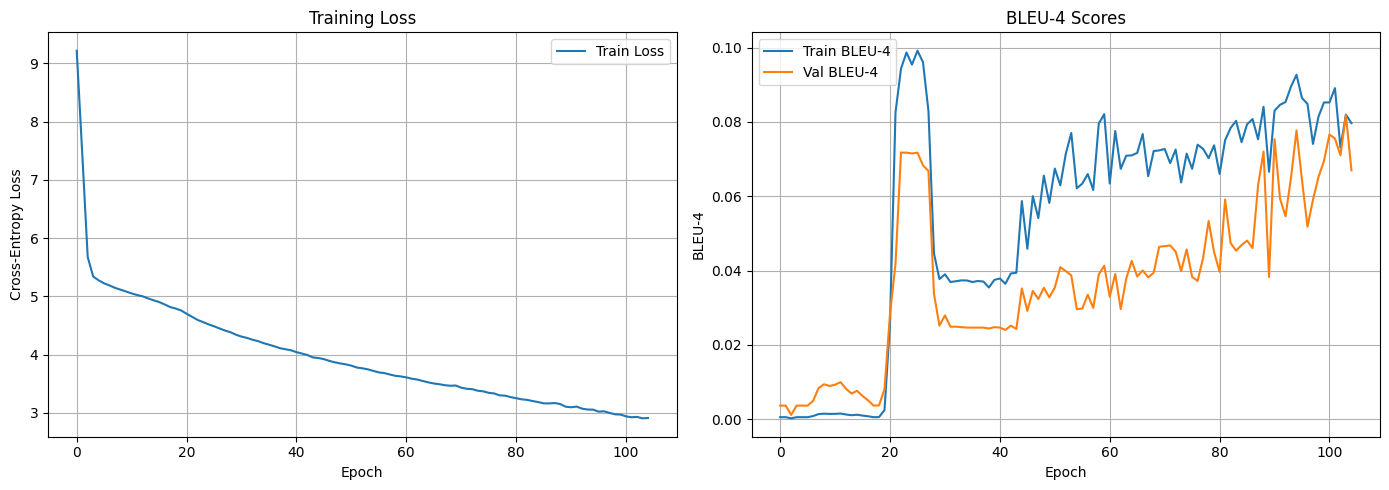

In [22]:
model.plot_history()

In [23]:
model.evaluate_bleu(processor.test_data)

100%|██████████| 100/100 [00:26<00:00,  3.71it/s]


BLEU-1: 0.4093
BLEU-2: 0.2333
BLEU-3: 0.1346
BLEU-4: 0.0829


{'bleu-1': 0.40928725701943847,
 'bleu-2': 0.23330552372461347,
 'bleu-3': 0.13459344410518911,
 'bleu-4': 0.0828562577515403}

In [24]:
samples = processor.train_data[:5]  # known to be from training set
for img_name, _ in samples:
    img_path = os.path.join(CONFIG['image_dir'], img_name)
    pred = model.greedy_decode(img_path)
    print("Predicted:", ' '.join(pred))
    print("Ground Truth:", processor.captions_dict[img_name][:1])


Predicted: a man in a blue shirt is is is standing on the beach .
Ground Truth: ['A yellow backhoe digging dirt and rocks in a field by a road .']
Predicted: a family is standing on the snow while other a family and other and other and other people and her and other and people in
Ground Truth: ['A man sporting London olympic wear carries a torch down a road lined with spectators while a yellow BMW follows him .']
Predicted: a man in a blue shirt and another black man in a yellow train .
Ground Truth: ['Competing skier going down the course leaning to make a sharp turn .']
Predicted: a man in a red shirt is and a dog is and a man .
Ground Truth: ['A toddler girl puckering up for a kiss from the dog .']
Predicted: a man in a red shirt and two people playing a bike in the snow .
Ground Truth: ['A dark-haired man in blue jeans and a light green polo is standing next to a man with khaki cargo shorts and a blue polo as they pose for a picture with locals in a foreign land .']


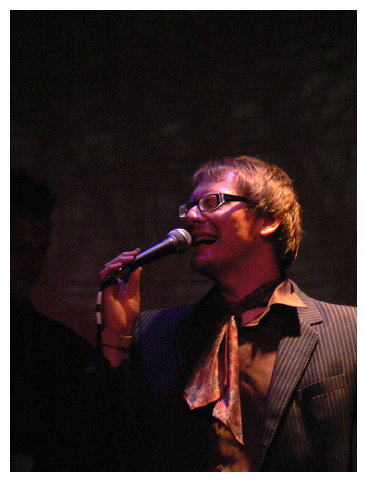

Ground-truth captions:
- A man wearing glasses is singing into a microphone .
- A pastor preaching in front of his congregation .
- A singer sings in the evening at a nightclub .
- A man singing on stage with his eyes closed .
- A man singing into a microphone .

Generated caption:
a man in a blue shirt is standing on the water .


Audio saved to caption_audio01.mp3


/tmp/ipykernel_46880/2502600238.py:345: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  alpha_resized = Image.fromarray(np.uint8(255 * alpha)).resize((299, 299), resample=Image.BICUBIC)


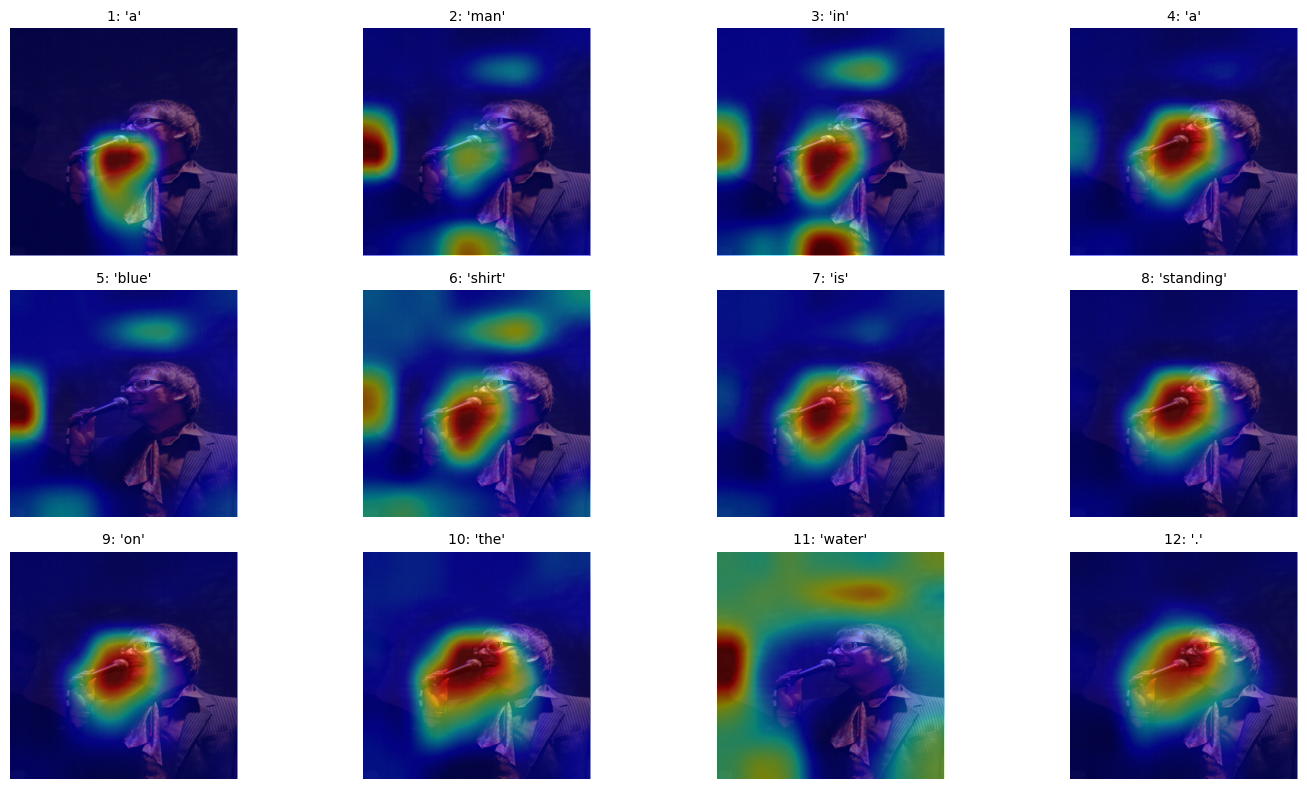

In [25]:
sample_pair = random.choice(processor.train_data)
sample_img = os.path.join(CONFIG['image_dir'], sample_pair[0])
model.demo(sample_img, filename='caption_audio01.mp3')

Debug image: 695100510.jpg


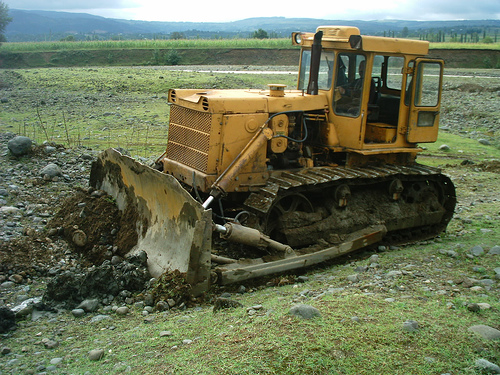


Captions from captions_dict:
 • A yellow backhoe digging dirt and rocks in a field by a road .
 • A male driving a bulldozer to plow green grass and rocks
 • A yellow tractor plows through muddy , green terrain .
 • A yellow bulldozer moves dirt in a rocky field .
 • A yellow bulldozer machine in a rocky field .

Caption from train_ds -> <start> a young girl wearing colorful clothing uses henna to draw a flower on her hand . <end>


In [31]:
# 1️⃣  Pick one filename from your 200-image subset
debug_img = next(iter(processor.train_data))[0]
print("Debug image:", debug_img)
display(Image.open(os.path.join(CONFIG['image_dir'], debug_img)))

# 2️⃣  Show what captions YOU THINK are ground truth
print("\nCaptions from captions_dict:")
for c in processor.captions_dict[debug_img]:
    print(" •", c)

# 3️⃣  Fetch the *exact* image–caption pair coming out of the tf.data pipeline
for batch in train_ds.take(1):
    img_tensor, token_ids, _ = batch
    # Convert first caption back to text
    words = [processor.tokenizer.index_word.get(i, '') for i in token_ids[0].numpy() if i != 0]
    print("\nCaption from train_ds ->", ' '.join(words))
    break


In [32]:
debug_ds = processor.build_dataset(
    processor.train_data,      # same list of (img, caption)
    shuffle=False,             # turn shuffle off
    cache=False,               # no caching needed
    training=True
)


In [33]:
(img_tensor, tok_ids, _) = next(iter(debug_ds))


In [34]:
img_name, cap_txt = processor.train_data[0]   # same order, no shuffle


In [39]:
# correct way – pick only the first sequence:
decoded = ' '.join(
    processor.tokenizer.index_word[i]
    for i in tok_ids[0].numpy() if i != 0               #  ← tok_ids[0] !
)
print("Decoded:", decoded)
print("GT     :", processor.train_data[0][1])


Decoded: <start> a yellow bulldozer moves dirt in a rocky field . <end>
GT     : <start> a yellow bulldozer moves dirt in a rocky field . <end>
